In [1]:
import jax
from jax import numpy as jp
import matplotlib.pyplot as plt
from IPython.display import HTML
from brax.io import model, html
import matplotlib.pyplot as plt 
#from sklearn.preprocessing import StandardScaler
#from sklearn.decomposition import PCA
from src import networks
from utils import get_env_config, create_env
import pickle
import numpy as np

ModuleNotFoundError: No module named 'src'

In [2]:
RUN_FOLDER_PATH = './runs/run_crl_1024_new_ul__s_1/'
CKPT_NAME = '/step_50853888.pkl'
# CKPT_NAME = '/step_10221568.pkl'

In [3]:
params = model.load_params(RUN_FOLDER_PATH + '/ckpt' + CKPT_NAME)
processor_params, policy_params, encoders_params = params
sa_encoder_params, g_encoder_params = encoders_params['sa_encoder'], encoders_params['g_encoder']

In [4]:
args_path = RUN_FOLDER_PATH + '/args.pkl'

with open(args_path, "rb") as f:
    args = pickle.load(f)

config = get_env_config(args)

In [5]:
env = create_env(args)
obs_size = env.observation_size
action_size = env.action_size

In [6]:
crl_networks = networks.make_crl_networks(config, env, obs_size, action_size, hidden_layer_sizes=(1024, 1024, 1024, 1024), use_ln=True)

inference_fn = networks.make_inference_fn(crl_networks)
inference_fn = inference_fn(params[:2])

sa_encoder = lambda obs: crl_networks.sa_encoder.apply(processor_params, sa_encoder_params, obs)
g_encoder = lambda obs: crl_networks.g_encoder.apply(processor_params, g_encoder_params, obs)

jit_env_reset = jax.jit(env.reset)
jit_env_step = jax.jit(env.step)
jit_inference_fn = jax.jit(inference_fn)

In [21]:
from brax.envs.base import State
from brax import base

In [70]:
def get_trajectory(seed, length=1000, deterministic=False, goal=None):
    inference_fn = networks.make_inference_fn(crl_networks)
    inference_fn = inference_fn(params[:2], deterministic=deterministic)
    jit_env_reset = jax.jit(env.reset)
    jit_env_step = jax.jit(env.step)
    jit_inference_fn = jax.jit(inference_fn)
    
    rng = jax.random.PRNGKey(seed=seed)

    state = jit_env_reset(rng=rng)
    trajectory = []
    for _ in range(length):
        obs = np.array(state.obs)
        if goal is not None:
            obs[-2:] = goal
        act_rng, rng = jax.random.split(rng)
        act, _ = jit_inference_fn(obs, act_rng)
        trajectory.append((state,act))
        state = jit_env_step(state, act)

    return trajectory, rng

In [23]:
def get_state(x, y, seed=0, step=5):
    
    trajectory = get_trajectory(seed, step)
    s = trajectory[-1][0]
    pipeline_state =  env.pipeline_init(s.pipeline_state.q.at[0].set(x).at[1].set(y), s.pipeline_state.qd)
    obs = env._get_obs(pipeline_state)
    
    reward, done, zero = jp.zeros(3)
    metrics = {
        "reward_forward": zero,
        "reward_survive": zero,
        "reward_ctrl": zero,
        "reward_contact": zero,
        "x_position": zero,
        "y_position": zero,
        "distance_from_origin": zero,
        "x_velocity": zero,
        "y_velocity": zero,
        "forward_reward": zero,
        "dist": zero,
        "success": zero,
        "success_easy": zero
    }
    info = {"seed": 0}
    state = State(pipeline_state, obs, reward, done, metrics)
    state.info.update(info)

    return state

In [24]:
def get_trajectory_starting(seed, starting, starting_traj_step=0, length=1000, deterministic=False):
    inference_fn = networks.make_inference_fn(crl_networks)
    inference_fn = inference_fn(params[:2], deterministic=deterministic)
    jit_env_reset = jax.jit(env.reset)
    jit_env_step = jax.jit(env.step)
    jit_inference_fn = jax.jit(inference_fn)
    
    rng = jax.random.PRNGKey(seed=seed)

    state = get_state(starting[0], starting[1], seed)
    trajectory = []
    
    for _ in range(length):
        obs = np.array(state.obs)
        act_rng, rng = jax.random.split(rng)
        act, _ = jit_inference_fn(obs, act_rng)
        trajectory.append((state,act))
        state = jit_env_step(state, act)

    return trajectory

In [25]:
def visualize_trajectory(trajectory):
    positions = [sa[0].obs[:2] for sa in trajectory]
    x = [pos[0] for pos in positions]
    y = [pos[1] for pos in positions]
    goal = trajectory[0][0].obs[-2:]

    colors = np.linspace(0, 1, len(positions))
    
    plt.scatter(y, x, c=colors, cmap='viridis', s=5)
    
    plt.plot([2, 14], [2, 2], color='red', linewidth=2)   # Line from (4,4) to (16,4)
    plt.plot([14, 14], [2, 14], color='red', linewidth=2) # Line from (16,4) to (16,16)
    plt.plot([14, 2], [14, 14], color='red', linewidth=2) # Line from (16,16) to (4,16)
    
    plt.plot([2, 10], [6, 6], color='red', linewidth=2)    # Line from (4,8) to (12,8)
    plt.plot([10, 10], [6, 10], color='red', linewidth=2)  # Line from (12,8) to (12,12)
    plt.plot([10, 2], [10, 10], color='red', linewidth=2)  # Line from (12,12) to (4,12)
    
    plt.plot([2, 2], [2, 6], color='red', linewidth=2)     # Line from (4,4) to (4,8)
    plt.plot([2, 2], [10, 14], color='red', linewidth=2)   # Line from (4,12) to (1,16)

    plt.scatter(goal[1], goal[0], color='black', s=100)
    plt.show()

In [26]:
def get_trajectory_starting(seed, starting, starting_traj_step=5, length=1000, deterministic=False, goal=None):
    inference_fn = networks.make_inference_fn(crl_networks)
    inference_fn = inference_fn(params[:2], deterministic=deterministic)
    jit_env_reset = jax.jit(env.reset)
    jit_env_step = jax.jit(env.step)
    jit_inference_fn = jax.jit(inference_fn)
    
    rng = jax.random.PRNGKey(seed=seed)

    state = get_state(starting[0], starting[1], seed, starting_traj_step)
    trajectory = []
    for _ in range(length):
        obs = np.array(state.obs)
        if goal is not None:
            obs[-2:] = goal
        act_rng, rng = jax.random.split(rng)
        act, _ = jit_inference_fn(obs, act_rng)
        trajectory.append((state,act))
        state = jit_env_step(state, act)

    return trajectory

In [79]:
def change_state(x, y, state):
    pipeline_state =  env.pipeline_init(state.pipeline_state.q.at[0].set(x).at[1].set(y), state.pipeline_state.qd)
    obs = env._get_obs(pipeline_state)
    
    reward, done, zero = jp.zeros(3)
    metrics = {
        "reward_forward": zero,
        "reward_survive": zero,
        "reward_ctrl": zero,
        "reward_contact": zero,
        "x_position": zero,
        "y_position": zero,
        "distance_from_origin": zero,
        "x_velocity": zero,
        "y_velocity": zero,
        "forward_reward": zero,
        "dist": zero,
        "success": zero,
        "success_easy": zero
    }
    info = {"seed": 0}
    s = State(pipeline_state, obs, reward, done, metrics)
    s.info.update(info)

    return s

In [77]:
def trajectory_from_state(state, rng, length, deterministic=False):
    
    trajectory = []
    
    for _ in range(length):
        act_rng, rng = jax.random.split(rng)
        act, _ = jit_inference_fn(state.obs, act_rng)
        trajectory.append((state,act))
        state = jit_env_step(state, act)

    return trajectory, rng

## "vector field"

In [53]:
def get_vector(seed, starting, length=30, deterministic=False):
    inference_fn = networks.make_inference_fn(crl_networks)
    inference_fn = inference_fn(params[:2], deterministic=deterministic)
    jit_env_reset = jax.jit(env.reset)
    jit_env_step = jax.jit(env.step)
    jit_inference_fn = jax.jit(inference_fn)

    trajectory = get_trajectory_starting(seed, starting, starting_traj_step=5, length=length, deterministic=deterministic)

    return trajectory[0][0].obs[:2], trajectory[-1][0].obs[:2], trajectory[0][0].obs[-2:]

In [95]:
def is_inside_u_maze(x, y):
    if 2 <= x <= 6 or 10 <= x <= 14:
        if 2 <= y <= 14:
            return True
        else:
            return False
    elif 6 <= x <= 10 and 10 <= y <= 14:
        return True
    else:
        return False
        

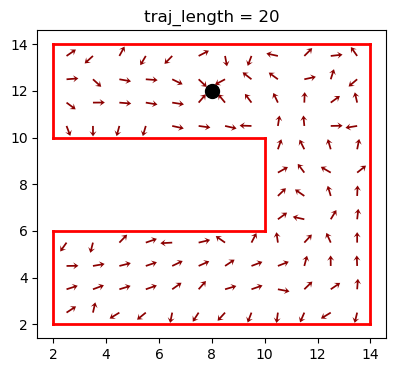

In [123]:
SEED = 4237
START_LENGTH = 5
DETERMINISTIC = True

TRAJ_LENGTH = 20

inference_fn = networks.make_inference_fn(crl_networks)
inference_fn = inference_fn(params[:2], deterministic=DETERMINISTIC)
jit_env_reset = jax.jit(env.reset)
jit_env_step = jax.jit(env.step)
jit_inference_fn = jax.jit(inference_fn)

trajectory_start, rng = get_trajectory(SEED, START_LENGTH)

x = np.linspace(2.5, 13.5, 12)
y = np.linspace(2.5, 13.5, 12)

plt.figure(figsize=(4.5, 4))

for i in range(len(x)):
    for j in range(len(y)):

        if is_inside_u_maze(x[i], y[j]):

            state = change_state(x[i], y[j], trajectory_start[-1][0])
    
            trajectory, rng = trajectory_from_state(state, rng, TRAJ_LENGTH)
            a = trajectory[0][0].obs[:2]
            b = trajectory[-1][0].obs[:2]
    
            vec = b - a
            nor = 0.45 * vec / (np.linalg.norm(vec))
    
            plt.quiver(a[1], a[0], nor[1], nor[0], angles='xy', scale_units='xy',
                       width=0.005, headwidth=4, headlength=3, scale=1, headaxislength=2, color='darkred')

        # print(i, j)

plt.plot([2, 14], [2, 2], color='red', linewidth=2)   # Line from (4,4) to (16,4)
plt.plot([14, 14], [2, 14], color='red', linewidth=2) # Line from (16,4) to (16,16)
plt.plot([14, 2], [14, 14], color='red', linewidth=2) # Line from (16,16) to (4,16)

plt.plot([2, 10], [6, 6], color='red', linewidth=2)    # Line from (4,8) to (12,8)
plt.plot([10, 10], [6, 10], color='red', linewidth=2)  # Line from (12,8) to (12,12)
plt.plot([10, 2], [10, 10], color='red', linewidth=2)  # Line from (12,12) to (4,12)

plt.plot([2, 2], [2, 6], color='red', linewidth=2)     # Line from (4,4) to (4,8)
plt.plot([2, 2], [10, 14], color='red', linewidth=2)   # Line from (4,12) to (1,16)

goal = trajectory_start[-1][0].obs[-2:]

plt.title("traj_length = %s" % TRAJ_LENGTH)

plt.scatter(goal[1], goal[0], color='black', s=100)

plt.show()   

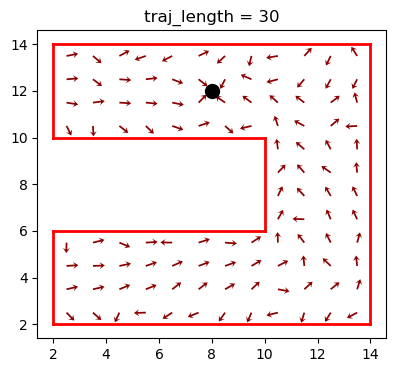

In [124]:
SEED = 4237
START_LENGTH = 5
DETERMINISTIC = True

TRAJ_LENGTH = 30

inference_fn = networks.make_inference_fn(crl_networks)
inference_fn = inference_fn(params[:2], deterministic=DETERMINISTIC)
jit_env_reset = jax.jit(env.reset)
jit_env_step = jax.jit(env.step)
jit_inference_fn = jax.jit(inference_fn)

trajectory_start, rng = get_trajectory(SEED, START_LENGTH)

x = np.linspace(2.5, 13.5, 12)
y = np.linspace(2.5, 13.5, 12)

plt.figure(figsize=(4.5, 4))

for i in range(len(x)):
    for j in range(len(y)):

        if is_inside_u_maze(x[i], y[j]):

            state = change_state(x[i], y[j], trajectory_start[-1][0])
    
            trajectory, rng = trajectory_from_state(state, rng, TRAJ_LENGTH)
            a = trajectory[0][0].obs[:2]
            b = trajectory[-1][0].obs[:2]
    
            vec = b - a
            nor = 0.45 * vec / (np.linalg.norm(vec))
    
            plt.quiver(a[1], a[0], nor[1], nor[0], angles='xy', scale_units='xy',
                       width=0.005, headwidth=4, headlength=3, scale=1, headaxislength=2, color='darkred')

        # print(i, j)

plt.plot([2, 14], [2, 2], color='red', linewidth=2)   # Line from (4,4) to (16,4)
plt.plot([14, 14], [2, 14], color='red', linewidth=2) # Line from (16,4) to (16,16)
plt.plot([14, 2], [14, 14], color='red', linewidth=2) # Line from (16,16) to (4,16)

plt.plot([2, 10], [6, 6], color='red', linewidth=2)    # Line from (4,8) to (12,8)
plt.plot([10, 10], [6, 10], color='red', linewidth=2)  # Line from (12,8) to (12,12)
plt.plot([10, 2], [10, 10], color='red', linewidth=2)  # Line from (12,12) to (4,12)

plt.plot([2, 2], [2, 6], color='red', linewidth=2)     # Line from (4,4) to (4,8)
plt.plot([2, 2], [10, 14], color='red', linewidth=2)   # Line from (4,12) to (1,16)

goal = trajectory_start[-1][0].obs[-2:]

plt.title("traj_length = %s" % TRAJ_LENGTH)

plt.scatter(goal[1], goal[0], color='black', s=100)

plt.show()   

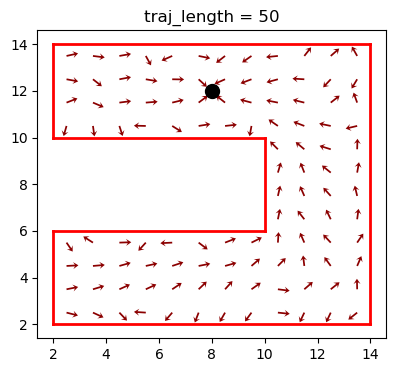

In [125]:
SEED = 4237
START_LENGTH = 5
DETERMINISTIC = True

TRAJ_LENGTH = 50

inference_fn = networks.make_inference_fn(crl_networks)
inference_fn = inference_fn(params[:2], deterministic=DETERMINISTIC)
jit_env_reset = jax.jit(env.reset)
jit_env_step = jax.jit(env.step)
jit_inference_fn = jax.jit(inference_fn)

trajectory_start, rng = get_trajectory(SEED, START_LENGTH)

x = np.linspace(2.5, 13.5, 12)
y = np.linspace(2.5, 13.5, 12)

plt.figure(figsize=(4.5, 4))

for i in range(len(x)):
    for j in range(len(y)):

        if is_inside_u_maze(x[i], y[j]):

            state = change_state(x[i], y[j], trajectory_start[-1][0])
    
            trajectory, rng = trajectory_from_state(state, rng, TRAJ_LENGTH)
            a = trajectory[0][0].obs[:2]
            b = trajectory[-1][0].obs[:2]
    
            vec = b - a
            nor = 0.45 * vec / (np.linalg.norm(vec))
    
            plt.quiver(a[1], a[0], nor[1], nor[0], angles='xy', scale_units='xy',
                       width=0.005, headwidth=4, headlength=3, scale=1, headaxislength=2, color='darkred')

        # print(i, j)

plt.plot([2, 14], [2, 2], color='red', linewidth=2)   # Line from (4,4) to (16,4)
plt.plot([14, 14], [2, 14], color='red', linewidth=2) # Line from (16,4) to (16,16)
plt.plot([14, 2], [14, 14], color='red', linewidth=2) # Line from (16,16) to (4,16)

plt.plot([2, 10], [6, 6], color='red', linewidth=2)    # Line from (4,8) to (12,8)
plt.plot([10, 10], [6, 10], color='red', linewidth=2)  # Line from (12,8) to (12,12)
plt.plot([10, 2], [10, 10], color='red', linewidth=2)  # Line from (12,12) to (4,12)

plt.plot([2, 2], [2, 6], color='red', linewidth=2)     # Line from (4,4) to (4,8)
plt.plot([2, 2], [10, 14], color='red', linewidth=2)   # Line from (4,12) to (1,16)

goal = trajectory_start[-1][0].obs[-2:]

plt.title("traj_length = %s" % TRAJ_LENGTH)

plt.scatter(goal[1], goal[0], color='black', s=100)

plt.show()   

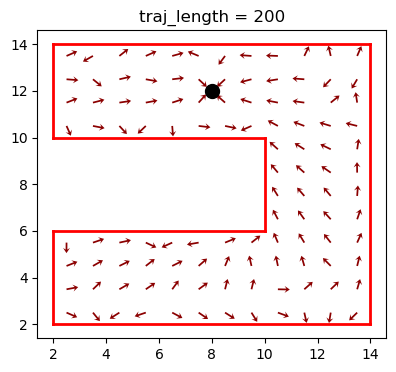

In [127]:
SEED = 4237
START_LENGTH = 5
DETERMINISTIC = True

TRAJ_LENGTH = 200

inference_fn = networks.make_inference_fn(crl_networks)
inference_fn = inference_fn(params[:2], deterministic=DETERMINISTIC)
jit_env_reset = jax.jit(env.reset)
jit_env_step = jax.jit(env.step)
jit_inference_fn = jax.jit(inference_fn)

trajectory_start, rng = get_trajectory(SEED, START_LENGTH)

x = np.linspace(2.5, 13.5, 12)
y = np.linspace(2.5, 13.5, 12)

plt.figure(figsize=(4.5, 4))

for i in range(len(x)):
    for j in range(len(y)):

        if is_inside_u_maze(x[i], y[j]):

            state = change_state(x[i], y[j], trajectory_start[-1][0])
    
            trajectory, rng = trajectory_from_state(state, rng, TRAJ_LENGTH)
            a = trajectory[0][0].obs[:2]
            b = trajectory[-1][0].obs[:2]
    
            vec = b - a
            nor = 0.45 * vec / (np.linalg.norm(vec))
    
            plt.quiver(a[1], a[0], nor[1], nor[0], angles='xy', scale_units='xy',
                       width=0.005, headwidth=4, headlength=3, scale=1, headaxislength=2, color='darkred')

        # print(i, j)

plt.plot([2, 14], [2, 2], color='red', linewidth=2)   # Line from (4,4) to (16,4)
plt.plot([14, 14], [2, 14], color='red', linewidth=2) # Line from (16,4) to (16,16)
plt.plot([14, 2], [14, 14], color='red', linewidth=2) # Line from (16,16) to (4,16)

plt.plot([2, 10], [6, 6], color='red', linewidth=2)    # Line from (4,8) to (12,8)
plt.plot([10, 10], [6, 10], color='red', linewidth=2)  # Line from (12,8) to (12,12)
plt.plot([10, 2], [10, 10], color='red', linewidth=2)  # Line from (12,12) to (4,12)

plt.plot([2, 2], [2, 6], color='red', linewidth=2)     # Line from (4,4) to (4,8)
plt.plot([2, 2], [10, 14], color='red', linewidth=2)   # Line from (4,12) to (1,16)

goal = trajectory_start[-1][0].obs[-2:]

plt.title("traj_length = %s" % TRAJ_LENGTH)

plt.scatter(goal[1], goal[0], color='black', s=100)

plt.show()   

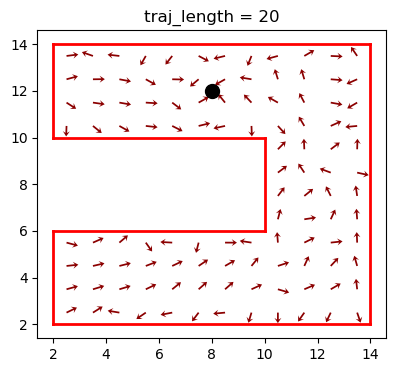

In [128]:
SEED = 4237
START_LENGTH = 5
DETERMINISTIC = False

TRAJ_LENGTH = 20

inference_fn = networks.make_inference_fn(crl_networks)
inference_fn = inference_fn(params[:2], deterministic=DETERMINISTIC)
jit_env_reset = jax.jit(env.reset)
jit_env_step = jax.jit(env.step)
jit_inference_fn = jax.jit(inference_fn)

trajectory_start, rng = get_trajectory(SEED, START_LENGTH)

x = np.linspace(2.5, 13.5, 12)
y = np.linspace(2.5, 13.5, 12)

plt.figure(figsize=(4.5, 4))

for i in range(len(x)):
    for j in range(len(y)):

        if is_inside_u_maze(x[i], y[j]):

            state = change_state(x[i], y[j], trajectory_start[-1][0])
    
            trajectory, rng = trajectory_from_state(state, rng, TRAJ_LENGTH)
            a = trajectory[0][0].obs[:2]
            b = trajectory[-1][0].obs[:2]
    
            vec = b - a
            nor = 0.45 * vec / (np.linalg.norm(vec))
    
            plt.quiver(a[1], a[0], nor[1], nor[0], angles='xy', scale_units='xy',
                       width=0.005, headwidth=4, headlength=3, scale=1, headaxislength=2, color='darkred')

        # print(i, j)

plt.plot([2, 14], [2, 2], color='red', linewidth=2)   # Line from (4,4) to (16,4)
plt.plot([14, 14], [2, 14], color='red', linewidth=2) # Line from (16,4) to (16,16)
plt.plot([14, 2], [14, 14], color='red', linewidth=2) # Line from (16,16) to (4,16)

plt.plot([2, 10], [6, 6], color='red', linewidth=2)    # Line from (4,8) to (12,8)
plt.plot([10, 10], [6, 10], color='red', linewidth=2)  # Line from (12,8) to (12,12)
plt.plot([10, 2], [10, 10], color='red', linewidth=2)  # Line from (12,12) to (4,12)

plt.plot([2, 2], [2, 6], color='red', linewidth=2)     # Line from (4,4) to (4,8)
plt.plot([2, 2], [10, 14], color='red', linewidth=2)   # Line from (4,12) to (1,16)

goal = trajectory_start[-1][0].obs[-2:]

plt.title("traj_length = %s" % TRAJ_LENGTH)

plt.scatter(goal[1], goal[0], color='black', s=100)

plt.show()   

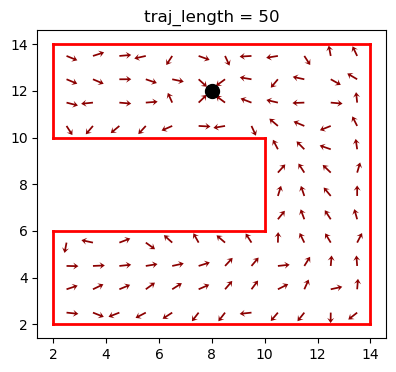

In [129]:
SEED = 4237
START_LENGTH = 5
DETERMINISTIC = False

TRAJ_LENGTH = 50

inference_fn = networks.make_inference_fn(crl_networks)
inference_fn = inference_fn(params[:2], deterministic=DETERMINISTIC)
jit_env_reset = jax.jit(env.reset)
jit_env_step = jax.jit(env.step)
jit_inference_fn = jax.jit(inference_fn)

trajectory_start, rng = get_trajectory(SEED, START_LENGTH)

x = np.linspace(2.5, 13.5, 12)
y = np.linspace(2.5, 13.5, 12)

plt.figure(figsize=(4.5, 4))

for i in range(len(x)):
    for j in range(len(y)):

        if is_inside_u_maze(x[i], y[j]):

            state = change_state(x[i], y[j], trajectory_start[-1][0])
    
            trajectory, rng = trajectory_from_state(state, rng, TRAJ_LENGTH)
            a = trajectory[0][0].obs[:2]
            b = trajectory[-1][0].obs[:2]
    
            vec = b - a
            nor = 0.45 * vec / (np.linalg.norm(vec))
    
            plt.quiver(a[1], a[0], nor[1], nor[0], angles='xy', scale_units='xy',
                       width=0.005, headwidth=4, headlength=3, scale=1, headaxislength=2, color='darkred')

        # print(i, j)

plt.plot([2, 14], [2, 2], color='red', linewidth=2)   # Line from (4,4) to (16,4)
plt.plot([14, 14], [2, 14], color='red', linewidth=2) # Line from (16,4) to (16,16)
plt.plot([14, 2], [14, 14], color='red', linewidth=2) # Line from (16,16) to (4,16)

plt.plot([2, 10], [6, 6], color='red', linewidth=2)    # Line from (4,8) to (12,8)
plt.plot([10, 10], [6, 10], color='red', linewidth=2)  # Line from (12,8) to (12,12)
plt.plot([10, 2], [10, 10], color='red', linewidth=2)  # Line from (12,12) to (4,12)

plt.plot([2, 2], [2, 6], color='red', linewidth=2)     # Line from (4,4) to (4,8)
plt.plot([2, 2], [10, 14], color='red', linewidth=2)   # Line from (4,12) to (1,16)

goal = trajectory_start[-1][0].obs[-2:]

plt.title("traj_length = %s" % TRAJ_LENGTH)

plt.scatter(goal[1], goal[0], color='black', s=100)

plt.show()   

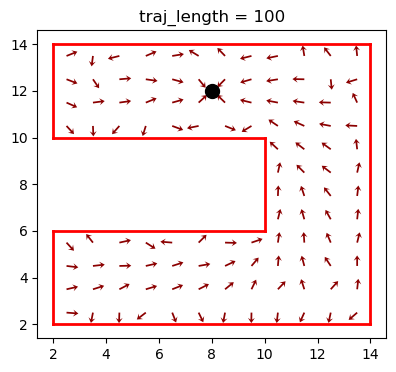

In [130]:
SEED = 4237
START_LENGTH = 5
DETERMINISTIC = False

TRAJ_LENGTH = 100

inference_fn = networks.make_inference_fn(crl_networks)
inference_fn = inference_fn(params[:2], deterministic=DETERMINISTIC)
jit_env_reset = jax.jit(env.reset)
jit_env_step = jax.jit(env.step)
jit_inference_fn = jax.jit(inference_fn)

trajectory_start, rng = get_trajectory(SEED, START_LENGTH)

x = np.linspace(2.5, 13.5, 12)
y = np.linspace(2.5, 13.5, 12)

plt.figure(figsize=(4.5, 4))

for i in range(len(x)):
    for j in range(len(y)):

        if is_inside_u_maze(x[i], y[j]):

            state = change_state(x[i], y[j], trajectory_start[-1][0])
    
            trajectory, rng = trajectory_from_state(state, rng, TRAJ_LENGTH)
            a = trajectory[0][0].obs[:2]
            b = trajectory[-1][0].obs[:2]
    
            vec = b - a
            nor = 0.45 * vec / (np.linalg.norm(vec))
    
            plt.quiver(a[1], a[0], nor[1], nor[0], angles='xy', scale_units='xy',
                       width=0.005, headwidth=4, headlength=3, scale=1, headaxislength=2, color='darkred')

        # print(i, j)

plt.plot([2, 14], [2, 2], color='red', linewidth=2)   # Line from (4,4) to (16,4)
plt.plot([14, 14], [2, 14], color='red', linewidth=2) # Line from (16,4) to (16,16)
plt.plot([14, 2], [14, 14], color='red', linewidth=2) # Line from (16,16) to (4,16)

plt.plot([2, 10], [6, 6], color='red', linewidth=2)    # Line from (4,8) to (12,8)
plt.plot([10, 10], [6, 10], color='red', linewidth=2)  # Line from (12,8) to (12,12)
plt.plot([10, 2], [10, 10], color='red', linewidth=2)  # Line from (12,12) to (4,12)

plt.plot([2, 2], [2, 6], color='red', linewidth=2)     # Line from (4,4) to (4,8)
plt.plot([2, 2], [10, 14], color='red', linewidth=2)   # Line from (4,12) to (1,16)

goal = trajectory_start[-1][0].obs[-2:]

plt.title("traj_length = %s" % TRAJ_LENGTH)

plt.scatter(goal[1], goal[0], color='black', s=100)

plt.show()   

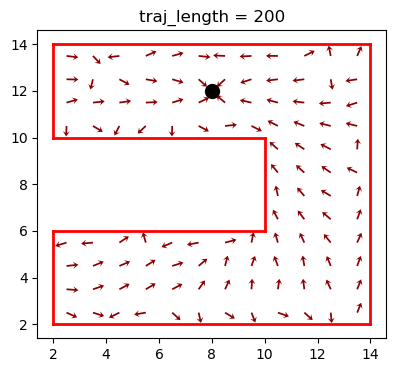

In [131]:
SEED = 4237
START_LENGTH = 5
DETERMINISTIC = False

TRAJ_LENGTH = 200

inference_fn = networks.make_inference_fn(crl_networks)
inference_fn = inference_fn(params[:2], deterministic=DETERMINISTIC)
jit_env_reset = jax.jit(env.reset)
jit_env_step = jax.jit(env.step)
jit_inference_fn = jax.jit(inference_fn)

trajectory_start, rng = get_trajectory(SEED, START_LENGTH)

x = np.linspace(2.5, 13.5, 12)
y = np.linspace(2.5, 13.5, 12)

plt.figure(figsize=(4.5, 4))

for i in range(len(x)):
    for j in range(len(y)):

        if is_inside_u_maze(x[i], y[j]):

            state = change_state(x[i], y[j], trajectory_start[-1][0])
    
            trajectory, rng = trajectory_from_state(state, rng, TRAJ_LENGTH)
            a = trajectory[0][0].obs[:2]
            b = trajectory[-1][0].obs[:2]
    
            vec = b - a
            nor = 0.45 * vec / (np.linalg.norm(vec))
    
            plt.quiver(a[1], a[0], nor[1], nor[0], angles='xy', scale_units='xy',
                       width=0.005, headwidth=4, headlength=3, scale=1, headaxislength=2, color='darkred')

        # print(i, j)

plt.plot([2, 14], [2, 2], color='red', linewidth=2)   # Line from (4,4) to (16,4)
plt.plot([14, 14], [2, 14], color='red', linewidth=2) # Line from (16,4) to (16,16)
plt.plot([14, 2], [14, 14], color='red', linewidth=2) # Line from (16,16) to (4,16)

plt.plot([2, 10], [6, 6], color='red', linewidth=2)    # Line from (4,8) to (12,8)
plt.plot([10, 10], [6, 10], color='red', linewidth=2)  # Line from (12,8) to (12,12)
plt.plot([10, 2], [10, 10], color='red', linewidth=2)  # Line from (12,12) to (4,12)

plt.plot([2, 2], [2, 6], color='red', linewidth=2)     # Line from (4,4) to (4,8)
plt.plot([2, 2], [10, 14], color='red', linewidth=2)   # Line from (4,12) to (1,16)

goal = trajectory_start[-1][0].obs[-2:]

plt.title("traj_length = %s" % TRAJ_LENGTH)

plt.scatter(goal[1], goal[0], color='black', s=100)

plt.show()   

In [ ]:
SEED = 4237
START_LENGTH = 5
DETERMINISTIC = False

TRAJ_LENGTH = 50

inference_fn = networks.make_inference_fn(crl_networks)
inference_fn = inference_fn(params[:2], deterministic=DETERMINISTIC)
jit_env_reset = jax.jit(env.reset)
jit_env_step = jax.jit(env.step)
jit_inference_fn = jax.jit(inference_fn)

trajectory_start, rng = get_trajectory(SEED, 1000)

x = np.linspace(2.5, 13.5, 12)
y = np.linspace(2.5, 13.5, 12)

plt.figure(figsize=(4.5, 4))

positions = [sa[0].obs[:2] for sa in trajectory_start]

x = [pos[0] for pos in positions]
y = [pos[1] for pos in positions]

colors = np.linspace(0, 1, len(positions))

plt.scatter(y, x, c=colors, cmap='viridis', s=5)

for i in range(len(x)):
    for j in range(len(y)):

        if is_inside_u_maze(x[i], y[j]):

            state = change_state(x[i], y[j], trajectory_start[START_LENGTH-1][0])
    
            trajectory, rng = trajectory_from_state(state, rng, TRAJ_LENGTH)
            a = trajectory[0][0].obs[:2]
            b = trajectory[-1][0].obs[:2]
    
            vec = b - a
            nor = 0.45 * vec / (np.linalg.norm(vec))
    
            plt.quiver(a[1], a[0], nor[1], nor[0], angles='xy', scale_units='xy',
                       width=0.005, headwidth=4, headlength=3, scale=1, headaxislength=2, color='darkred')

        # print(i, j)

plt.plot([2, 14], [2, 2], color='red', linewidth=2)   # Line from (4,4) to (16,4)
plt.plot([14, 14], [2, 14], color='red', linewidth=2) # Line from (16,4) to (16,16)
plt.plot([14, 2], [14, 14], color='red', linewidth=2) # Line from (16,16) to (4,16)

plt.plot([2, 10], [6, 6], color='red', linewidth=2)    # Line from (4,8) to (12,8)
plt.plot([10, 10], [6, 10], color='red', linewidth=2)  # Line from (12,8) to (12,12)
plt.plot([10, 2], [10, 10], color='red', linewidth=2)  # Line from (12,12) to (4,12)

plt.plot([2, 2], [2, 6], color='red', linewidth=2)     # Line from (4,4) to (4,8)
plt.plot([2, 2], [10, 14], color='red', linewidth=2)   # Line from (4,12) to (1,16)

goal = trajectory_start[-1][0].obs[-2:]

plt.title("traj_length = %s" % TRAJ_LENGTH)

plt.scatter(goal[1], goal[0], color='black', s=100)

plt.show()   

0 0


2024-10-24 13:18:43.324407: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 38.61312669s
Constant folding an instruction is taking > 1s:

  %reshape.1146 = s32[72,1]{1,0} reshape(s32[72]{0} %constant.1794), metadata={op_name="jit(step)/jit(main)/while/body/broadcast_in_dim" source_file="/home/tomek/repos/JaxGCRL/envs/ant_maze.py" source_line=271}

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.


0 1
0 2
0 3
0 4


2024-10-24 13:21:03.562407: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 38.843963996s
Constant folding an instruction is taking > 1s:

  %reshape.1028 = f32[37]{0} reshape(f32[37,1]{1,0} %constant.1667), metadata={op_name="jit(step)/jit(main)/while/body/squeeze" source_file="/home/tomek/repos/JaxGCRL/envs/ant_maze.py" source_line=271}

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.


1 0
1 1
1 2
1 3


KeyboardInterrupt: 

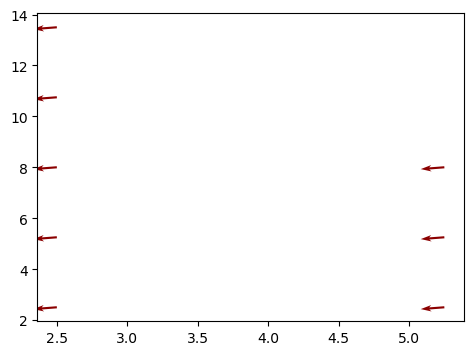

In [60]:
SEED = 4237
LENGTH = 20

x = np.linspace(2.5, 13.5, 5)
y = np.linspace(2.5, 13.5, 5)

plt.figure(figsize=(5.5, 4))

for i in range(len(x)):
    for j in range(len(y)):
        print(i, j)
        a, b, goal = get_vector(SEED, [x[i], y[j]], LENGTH)

        direction = b - a
        direction_normalized = direction / np.linalg.norm(direction)

        plt.quiver(a[0], a[1], nor[0], nor[1], angles='xy', scale_units='xy',
                   width=0.005, headwidth=3, headlength=5, headaxislength=4, color='darkred')

        

plt.plot([2, 14], [2, 2], color='red', linewidth=2)   # Line from (4,4) to (16,4)
plt.plot([14, 14], [2, 14], color='red', linewidth=2) # Line from (16,4) to (16,16)
plt.plot([14, 2], [14, 14], color='red', linewidth=2) # Line from (16,16) to (4,16)

plt.plot([2, 10], [6, 6], color='red', linewidth=2)    # Line from (4,8) to (12,8)
plt.plot([10, 10], [6, 10], color='red', linewidth=2)  # Line from (12,8) to (12,12)
plt.plot([10, 2], [10, 10], color='red', linewidth=2)  # Line from (12,12) to (4,12)

plt.plot([2, 2], [2, 6], color='red', linewidth=2)     # Line from (4,4) to (4,8)
plt.plot([2, 2], [10, 14], color='red', linewidth=2)   # Line from (4,12) to (1,16)

plt.scatter(goal[1], goal[0], color='black', s=100)

plt.show()

In [29]:
plt.figure(figsize=(5.5, 4))
plt.scatter(X, Y, c=Z, cmap='viridis', marker='o')
plt.colorbar()

plt.plot([2, 14], [2, 2], color='red', linewidth=2)   # Line from (4,4) to (16,4)
plt.plot([14, 14], [2, 14], color='red', linewidth=2) # Line from (16,4) to (16,16)
plt.plot([14, 2], [14, 14], color='red', linewidth=2) # Line from (16,16) to (4,16)

plt.plot([2, 10], [6, 6], color='red', linewidth=2)    # Line from (4,8) to (12,8)
plt.plot([10, 10], [6, 10], color='red', linewidth=2)  # Line from (12,8) to (12,12)
plt.plot([10, 2], [10, 10], color='red', linewidth=2)  # Line from (12,12) to (4,12)

plt.plot([2, 2], [2, 6], color='red', linewidth=2)     # Line from (4,4) to (4,8)
plt.plot([2, 2], [10, 14], color='red', linewidth=2)   # Line from (4,12) to (1,16)

plt.scatter(goal[1], goal[0], color='black', s=100)

plt.show()

NameError: name 'X' is not defined

<Figure size 550x400 with 0 Axes>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define points A and B
A = a  # Starting point (A)
B = b  # End point (B)

# Compute the direction vector from A to B
direction = B - A

# Normalize the direction vector to have a length of 1
direction_normalized = direction / np.linalg.norm(direction)

# Plot the arrow
plt.figure()
plt.quiver(A[0], A[1], direction_normalized[0], direction_normalized[1], 
           angles='xy', scale_units='xy', scale=1, color='r')

# Set plot limits
plt.xlim(4, 6)
plt.ylim(10, 14)
plt.gca().set_aspect('equal', adjustable='box')

# Add labels and grid
plt.grid(True)
plt.title('Arrow from A to B (normalized to length 1)')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

# Show the plot
plt.show()


In [13]:
rng = jax.random.PRNGKey(seed=0)
state = jit_env_reset(rng=rng)

In [38]:
from copy import deepcopy

In [52]:
from brax.envs.base import State
from brax import base

In [56]:
seed = 0
step = 0
x = 5
y = 12.5

trajectory = get_trajectory(seed)
s = trajectory[5][0]
state = env.pipeline_init(s.pipeline_state.q.at[0].set(x).at[1].set(y), s.pipeline_state.qd)

In [61]:
def get_state(x, y, seed=0, step=5):
    trajectory = get_trajectory(seed)
    s = trajectory[step][0]
    return env.pipeline_init(s.pipeline_state.q.at[0].set(x).at[1].set(y), s.pipeline_state.qd)

FrozenInstanceError: cannot assign to field 'pipeline_state'

In [22]:
from brax.envs.base import State
from brax import base

In [23]:
base_state = b.pipeline_state

In [34]:
base_state.q.at[0:1].set([2, 2])

ValueError: Incompatible shapes for broadcasting: (2,) and requested shape (1,)

In [26]:
base_state.q[0] = 5

TypeError: '<class 'jaxlib.xla_extension.ArrayImpl'>' object does not support item assignment. JAX arrays are immutable. Instead of ``x[idx] = y``, use ``x = x.at[idx].set(y)`` or another .at[] method: https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.ndarray.at.html

In [19]:
b = State(state.pipeline_state, state.obs, state.reward, state.done, state.metrics)

## L2 plots

In [13]:
SEED = 4237

inference_fn = networks.make_inference_fn(crl_networks)
inference_fn = inference_fn(params[:2], deterministic=False)
    
jit_inference_fn = jax.jit(inference_fn)

trajectory = get_trajectory(SEED)

obs = np.array(trajectory[100][0].obs)
goal = obs[-2:]

x = np.linspace(0, 16, 50)
y = np.linspace(0, 16, 50)

X, Y = np.meshgrid(x, y)
Z = np.zeros_like(X)

rng = jax.random.PRNGKey(seed=SEED)

for i in range(len(x)):
    for j in range(len(y)):
        obs[:2] = (x[i], y[j])
        act_rng, rng = jax.random.split(rng)   
        action, _ = jit_inference_fn(obs, act_rng)
        act = np.array(action)
        
        encoded_state_action = sa_encoder(np.concatenate((obs[:-2], act), axis=0))
        encoded_goal = g_encoder(goal)
        l2_distance = np.linalg.norm(encoded_state_action - encoded_goal)
        Z[i, j] = - l2_distance

2024-10-23 12:44:43.921307: E external/xla/xla/service/slow_operation_alarm.cc:65] Constant folding an instruction is taking > 1s:

  %reduce.105 = pred[8]{0} reduce(pred[8,3]{1,0} %constant.1298, pred[] %constant.477), dimensions={1}, to_apply=%region_5.275, metadata={op_name="jit(step)/jit(main)/while/body/reduce_or" source_file="/home/tomek/repos/JaxGCRL/envs/ant_maze.py" source_line=271}

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.


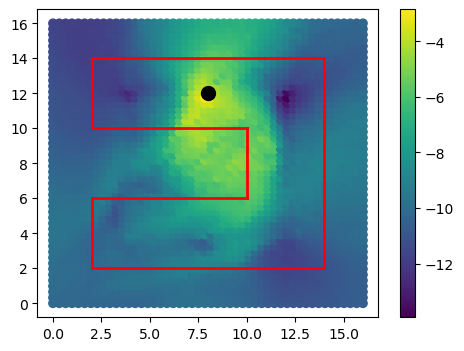

In [14]:
plt.figure(figsize=(5.5, 4))
plt.scatter(X, Y, c=Z, cmap='viridis', marker='o')
plt.colorbar()

plt.plot([2, 14], [2, 2], color='red', linewidth=2)   # Line from (4,4) to (16,4)
plt.plot([14, 14], [2, 14], color='red', linewidth=2) # Line from (16,4) to (16,16)
plt.plot([14, 2], [14, 14], color='red', linewidth=2) # Line from (16,16) to (4,16)

plt.plot([2, 10], [6, 6], color='red', linewidth=2)    # Line from (4,8) to (12,8)
plt.plot([10, 10], [6, 10], color='red', linewidth=2)  # Line from (12,8) to (12,12)
plt.plot([10, 2], [10, 10], color='red', linewidth=2)  # Line from (12,12) to (4,12)

plt.plot([2, 2], [2, 6], color='red', linewidth=2)     # Line from (4,4) to (4,8)
plt.plot([2, 2], [10, 14], color='red', linewidth=2)   # Line from (4,12) to (1,16)

plt.scatter(goal[1], goal[0], color='black', s=100)

plt.show()

In [24]:
seed = 541

for i in range(5):
    seed += 1
    trajectory = get_trajectory(seed, deterministic=False)
    print(trajectory[0][0].obs[-2:], trajectory[-1][0].metrics['reward_survive'])

[ 4.       11.999998] 1.0
[12. 12.] 1.0


KeyboardInterrupt: 

In [9]:
def plot_trajectory(seed):
    jit_env_reset = jax.jit(env.reset)
    jit_env_step = jax.jit(env.step)
    jit_inference_fn = jax.jit(inference_fn)
    
    trajectory = []
    rng = jax.random.PRNGKey(seed=seed)
    state = jit_env_reset(rng=rng)
    
    for _ in range(1000):
            # rollouts.append(state.pipeline_state)
        act_rng, rng = jax.random.split(rng)
        act, _ = jit_inference_fn(state.obs, act_rng)
        trajectory.append((state,act))
        state = jit_env_step(state, act)

    positions = [sa[0].obs[:2] for sa in trajectory]

    x = [pos[0] for pos in positions]
    y = [pos[1] for pos in positions]
    
    goal = trajectory[0][0].obs[-2:]

    colors = np.linspace(0, 1, len(positions))

    plt.scatter(y, x, c=colors, cmap='viridis', s=5)
    #plt.plot([4, 16], [4, 4], color='red', linewidth=2)   # Line from (4,4) to (16,4)
    #plt.plot([16, 16], [4, 16], color='red', linewidth=2) # Line from (16,4) to (16,16)
    #plt.plot([16, 4], [16, 16], color='red', linewidth=2) # Line from (16,16) to (4,16)
    
    #plt.plot([4, 12], [8, 8], color='red', linewidth=2)    # Line from (4,8) to (12,8)
    #plt.plot([12, 12], [8, 12], color='red', linewidth=2)  # Line from (12,8) to (12,12)
    #plt.plot([12, 4], [12, 12], color='red', linewidth=2)  # Line from (12,12) to (4,12)
    
    #plt.plot([4, 4], [4, 8], color='red', linewidth=2)     # Line from (4,4) to (4,8)
    #plt.plot([4, 4], [12, 16], color='red', linewidth=2)   # Line from (4,12) to (1,16)

    plt.plot([2, 14], [2, 2], color='red', linewidth=2)   # Line from (4,4) to (16,4)
    plt.plot([14, 14], [2, 14], color='red', linewidth=2) # Line from (16,4) to (16,16)
    plt.plot([14, 2], [14, 14], color='red', linewidth=2) # Line from (16,16) to (4,16)
    
    plt.plot([2, 10], [6, 6], color='red', linewidth=2)    # Line from (4,8) to (12,8)
    plt.plot([10, 10], [6, 10], color='red', linewidth=2)  # Line from (12,8) to (12,12)
    plt.plot([10, 2], [10, 10], color='red', linewidth=2)  # Line from (12,12) to (4,12)
    
    plt.plot([2, 2], [2, 6], color='red', linewidth=2)     # Line from (4,4) to (4,8)
    plt.plot([2, 2], [10, 14], color='red', linewidth=2)   # Line from (4,12) to (1,16)
    
    plt.scatter(goal[1], goal[0], color='black', s=100)

    success_time = np.sum([t[0].metrics['success'] for t in trajectory])
    plt.title("success_time=%s" % (int(success_time)))
    
    plt.show()

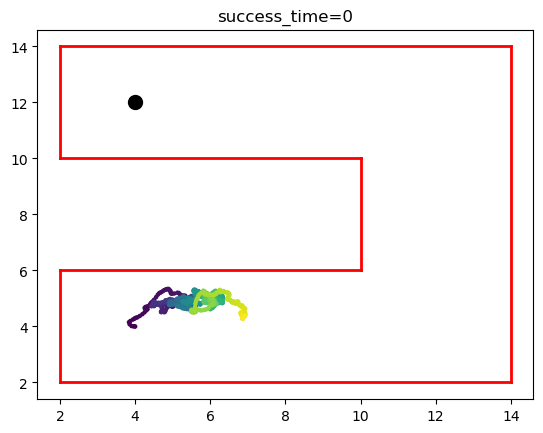

In [77]:
plot_trajectory(1561894)

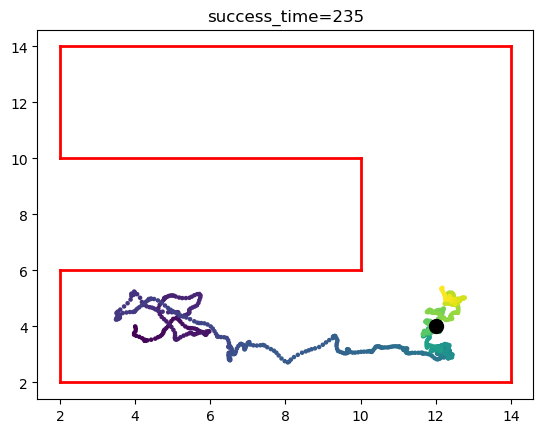

In [78]:
plot_trajectory(0)

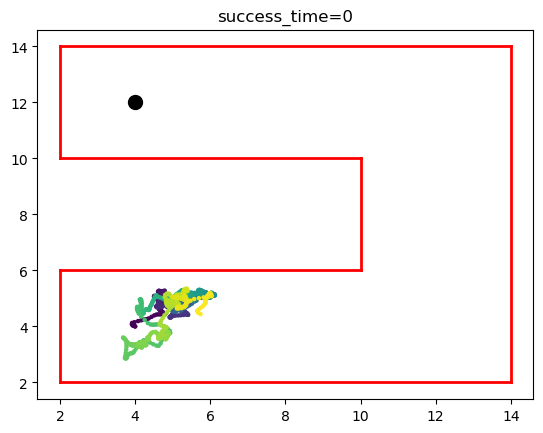

In [79]:
plot_trajectory(1)

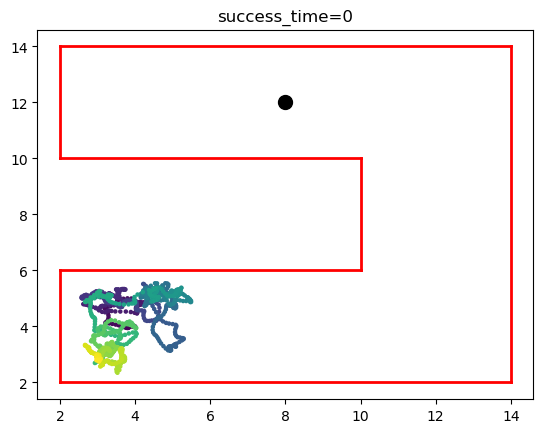

In [80]:
plot_trajectory(2)

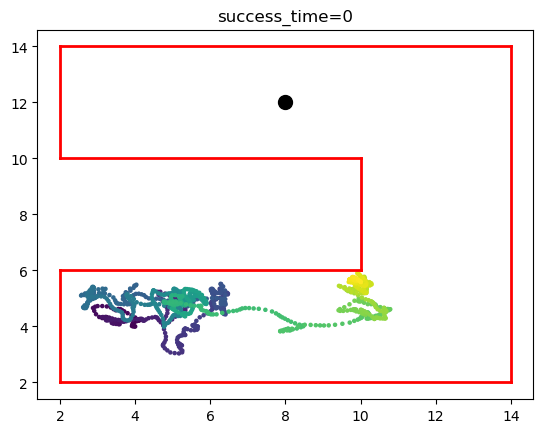

In [81]:
plot_trajectory(3)

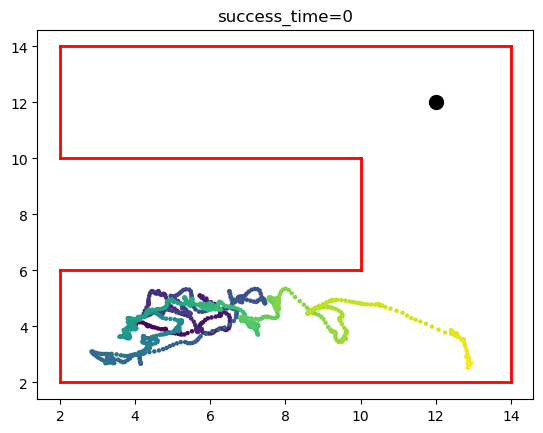

In [82]:
plot_trajectory(4)

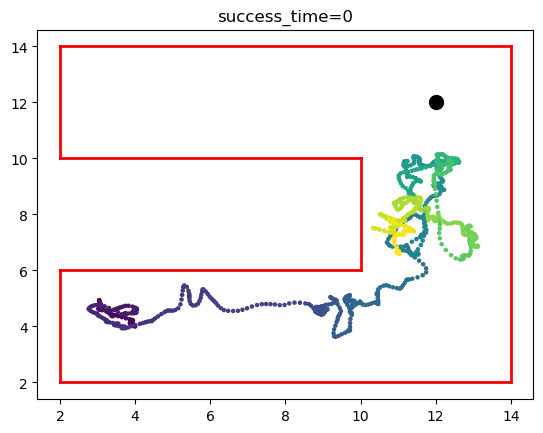

In [83]:
plot_trajectory(5)

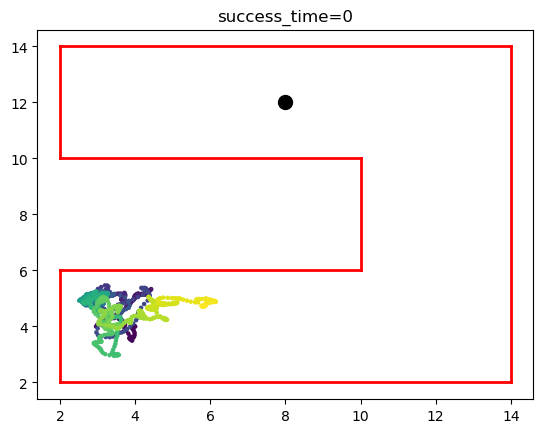

In [84]:
plot_trajectory(6)

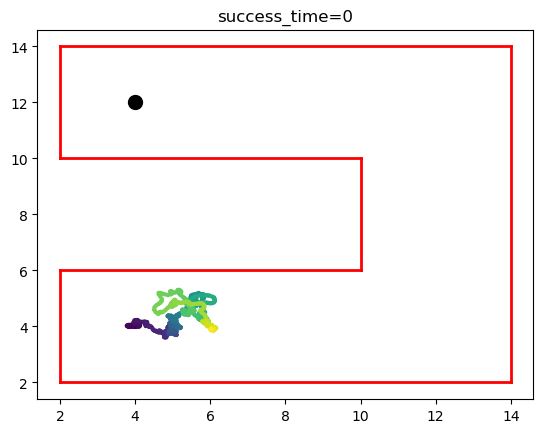

In [85]:
plot_trajectory(7)

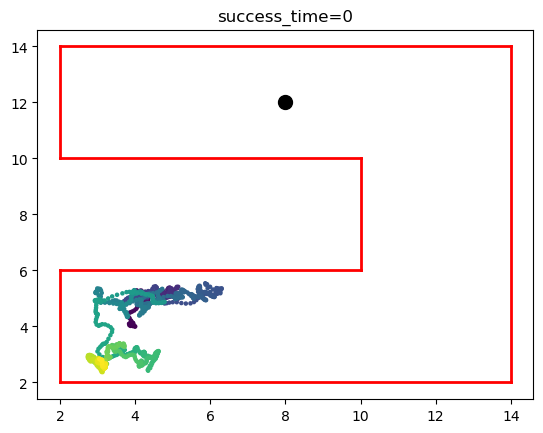

In [86]:
plot_trajectory(8)

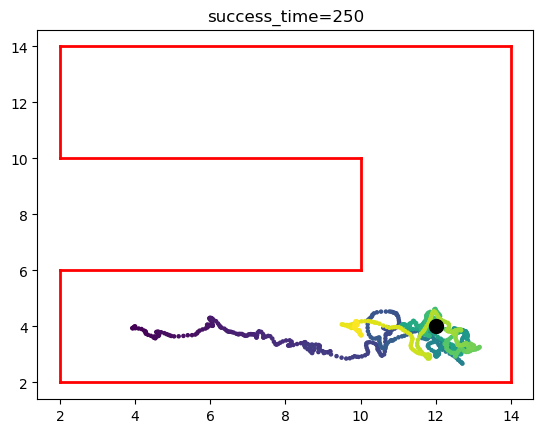

In [87]:
plot_trajectory(9)

In [35]:
trajectory = get_trajectory(5)

obs = np.array(trajectory[100][0].obs)
goal = obs[-2:]

x = np.linspace(0, 16, 60)
y = np.linspace(0, 16, 60)

X, Y = np.meshgrid(x, y)
Z = np.zeros_like(X)

rng = jax.random.PRNGKey(seed=5)

for i in range(len(x)):
    for j in range(len(y)):
        obs[:2] = (x[i], y[j])
        act_rng, rng = jax.random.split(rng)   
        action, _ = jit_inference_fn(obs, act_rng)
        act = np.array(action)
        
        encoded_state_action = sa_encoder(np.concatenate((obs[:-2], act), axis=0))
        encoded_goal = g_encoder(goal)
        l2_distance = np.linalg.norm(encoded_state_action - encoded_goal)
        Z[i, j] = -l2_distance

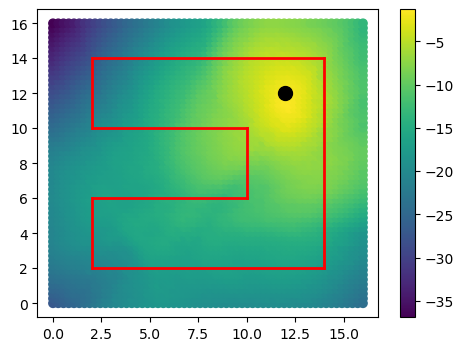

In [41]:
plt.figure(figsize=(5.5, 4))
plt.scatter(X, Y, c=Z, cmap='viridis', marker='o')
plt.colorbar()

plt.plot([2, 14], [2, 2], color='red', linewidth=2)   # Line from (4,4) to (16,4)
plt.plot([14, 14], [2, 14], color='red', linewidth=2) # Line from (16,4) to (16,16)
plt.plot([14, 2], [14, 14], color='red', linewidth=2) # Line from (16,16) to (4,16)

plt.plot([2, 10], [6, 6], color='red', linewidth=2)    # Line from (4,8) to (12,8)
plt.plot([10, 10], [6, 10], color='red', linewidth=2)  # Line from (12,8) to (12,12)
plt.plot([10, 2], [10, 10], color='red', linewidth=2)  # Line from (12,12) to (4,12)

plt.plot([2, 2], [2, 6], color='red', linewidth=2)     # Line from (4,4) to (4,8)
plt.plot([2, 2], [10, 14], color='red', linewidth=2)   # Line from (4,12) to (1,16)

plt.scatter(goal[1], goal[0], color='black', s=100)

plt.show()

In [97]:
Z = np.log(Z)

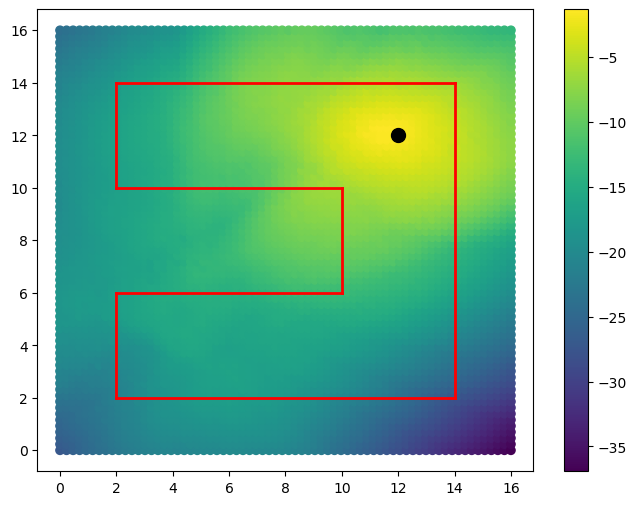

In [98]:
plt.figure(figsize=(8, 6))
plt.scatter(Y, X, c=Z, cmap='viridis', marker='o')
plt.colorbar()

plt.plot([2, 14], [2, 2], color='red', linewidth=2)   # Line from (4,4) to (16,4)
plt.plot([14, 14], [2, 14], color='red', linewidth=2) # Line from (16,4) to (16,16)
plt.plot([14, 2], [14, 14], color='red', linewidth=2) # Line from (16,16) to (4,16)

plt.plot([2, 10], [6, 6], color='red', linewidth=2)    # Line from (4,8) to (12,8)
plt.plot([10, 10], [6, 10], color='red', linewidth=2)  # Line from (12,8) to (12,12)
plt.plot([10, 2], [10, 10], color='red', linewidth=2)  # Line from (12,12) to (4,12)

plt.plot([2, 2], [2, 6], color='red', linewidth=2)     # Line from (4,4) to (4,8)
plt.plot([2, 2], [10, 14], color='red', linewidth=2)   # Line from (4,12) to (1,16)

plt.scatter(goal[1], goal[0], color='black', s=100)

plt.show()

In [17]:
from copy import deepcopy

0
1
2


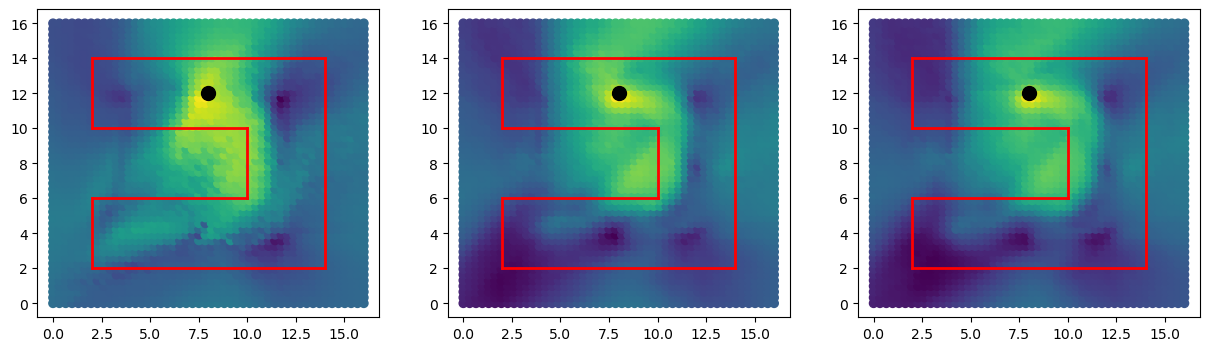

In [18]:
inference_fn = networks.make_inference_fn(crl_networks)
inference_fn = inference_fn(params[:2], deterministic=True)

trajectory = get_trajectory(4237)

fig, axs = plt.subplots(1, 3, figsize=(15, 4))

for k in range(3):
    print(k)
    obs = np.array(trajectory[10 + 300*k][0].obs)
    # starting_obs = deepcopy(obs)
    
    goal = obs[-2:]
    
    x = np.linspace(0, 16, 50)
    y = np.linspace(0, 16, 50)
    
    X, Y = np.meshgrid(x, y)
    Z = np.zeros_like(X)
    
    rng = jax.random.PRNGKey(seed=2)

    for i in range(len(x)):
        for j in range(len(y)):
            obs[:2] = (x[i], y[j])
            act_rng, rng = jax.random.split(rng)   
            action, _ = jit_inference_fn(obs, act_rng)
            act = np.array(action)
            
            encoded_state_action = sa_encoder(np.concatenate((obs[:-2], act), axis=0))
            encoded_goal = g_encoder(goal)
            l2_distance = np.linalg.norm(encoded_state_action - encoded_goal)
            Z[i, j] = -l2_distance

    axs[k].scatter(X, Y, c=Z, cmap='viridis', marker='o')

    axs[k].plot([2, 14], [2, 2], color='red', linewidth=2)   # Line from (4,4) to (16,4)
    axs[k].plot([14, 14], [2, 14], color='red', linewidth=2) # Line from (16,4) to (16,16)
    axs[k].plot([14, 2], [14, 14], color='red', linewidth=2) # Line from (16,16) to (4,16)
    
    axs[k].plot([2, 10], [6, 6], color='red', linewidth=2)    # Line from (4,8) to (12,8)
    axs[k].plot([10, 10], [6, 10], color='red', linewidth=2)  # Line from (12,8) to (12,12)
    axs[k].plot([10, 2], [10, 10], color='red', linewidth=2)  # Line from (12,12) to (4,12)
    
    axs[k].plot([2, 2], [2, 6], color='red', linewidth=2)     # Line from (4,4) to (4,8)
    axs[k].plot([2, 2], [10, 14], color='red', linewidth=2)   # Line from (4,12) to (1,16)
    
    axs[k].scatter(goal[1], goal[0], color='black', s=100)

    # axs[k].scatter(starting_obs[1], starting_obs[0], color='red', s=50)

plt.show()

0
1
2
3
4
5


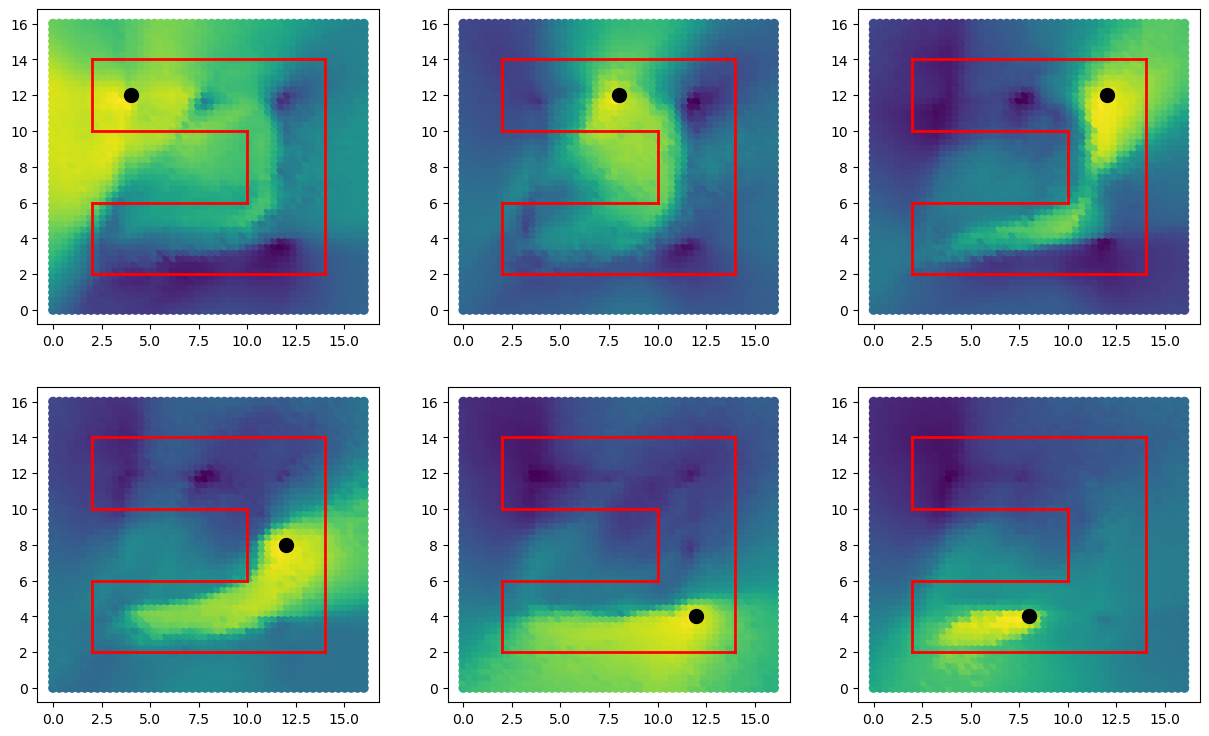

In [38]:
inference_fn = networks.make_inference_fn(crl_networks)
inference_fn = inference_fn(params[:2], deterministic=True)

trajectory = get_trajectory(65848)

fig, axs = plt.subplots(2, 3, figsize=(15, 9))

rng = jax.random.PRNGKey(seed=2)

obs = np.array(trajectory[50][0].obs)

goals = [(12, 4), (12, 8), (12, 12), (8, 12), (4, 12), (4, 8)]

for k in range(6):
    print(k)
    obs[-2:] = goals[k]
    goal = goals[k]
    x = np.linspace(0, 16, 50)
    y = np.linspace(0, 16, 50)
    X, Y = np.meshgrid(x, y)
    Z = np.zeros_like(X)

    for i in range(len(x)):
        for j in range(len(y)):
            obs[:2] = (x[i], y[j])
            act_rng, rng = jax.random.split(rng)   
            action, _ = jit_inference_fn(obs, act_rng)
            act = np.array(action)
            
            encoded_state_action = sa_encoder(np.concatenate((obs[:-2], act), axis=0))
            encoded_goal = g_encoder(goal)
            l2_distance = np.linalg.norm(encoded_state_action - encoded_goal)
            Z[i, j] = -l2_distance

    axs[k//3, k%3].scatter(X, Y, c=Z, cmap='viridis', marker='o')

    axs[k//3, k%3].plot([2, 14], [2, 2], color='red', linewidth=2)   # Line from (4,4) to (16,4)
    axs[k//3, k%3].plot([14, 14], [2, 14], color='red', linewidth=2) # Line from (16,4) to (16,16)
    axs[k//3, k%3].plot([14, 2], [14, 14], color='red', linewidth=2) # Line from (16,16) to (4,16)
    
    axs[k//3, k%3].plot([2, 10], [6, 6], color='red', linewidth=2)    # Line from (4,8) to (12,8)
    axs[k//3, k%3].plot([10, 10], [6, 10], color='red', linewidth=2)  # Line from (12,8) to (12,12)
    axs[k//3, k%3].plot([10, 2], [10, 10], color='red', linewidth=2)  # Line from (12,12) to (4,12)
    
    axs[k//3, k%3].plot([2, 2], [2, 6], color='red', linewidth=2)     # Line from (4,4) to (4,8)
    axs[k//3, k%3].plot([2, 2], [10, 14], color='red', linewidth=2)   # Line from (4,12) to (1,16)
    
    axs[k//3, k%3].scatter(goal[1], goal[0], color='black', s=100)

plt.show()

0
1
2
3
4
5


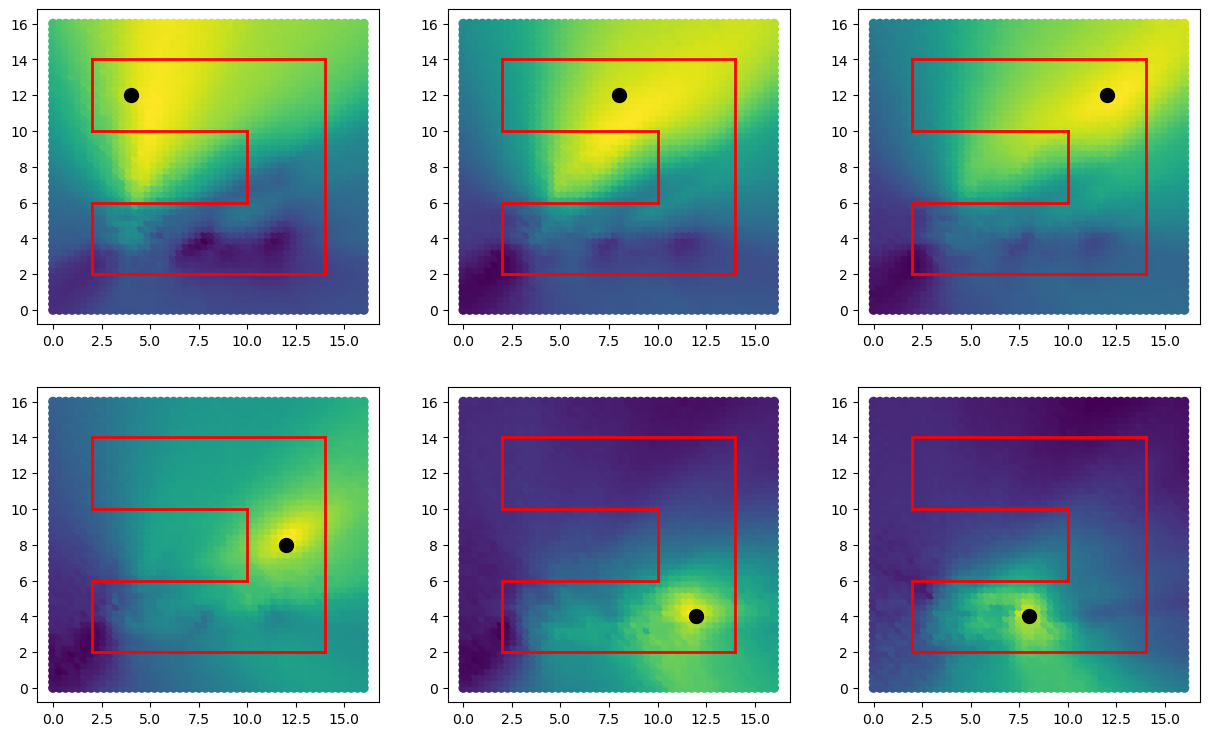

In [45]:
inference_fn = networks.make_inference_fn(crl_networks)
inference_fn = inference_fn(params[:2], deterministic=True)

trajectory = get_trajectory(65848)

fig, axs = plt.subplots(2, 3, figsize=(15, 9))

rng = jax.random.PRNGKey(seed=2)

obs = np.array(trajectory[50][0].obs)

goals = [(12, 4), (12, 8), (12, 12), (8, 12), (4, 12), (4, 8)]

for k in range(6):
    print(k)
    obs[-2:] = goals[k]
    goal = goals[k]
    x = np.linspace(0, 16, 50)
    y = np.linspace(0, 16, 50)
    X, Y = np.meshgrid(x, y)
    Z = np.zeros_like(X)

    for i in range(len(x)):
        for j in range(len(y)):
            obs[:2] = (x[i], y[j])
            act_rng, rng = jax.random.split(rng)   
            action, _ = jit_inference_fn(obs, act_rng)
            act = np.array(action)
            
            encoded_state_action = sa_encoder(np.concatenate((obs[:-2], act), axis=0))
            encoded_goal = g_encoder(goal)
            l2_distance = np.linalg.norm(encoded_state_action - encoded_goal)
            Z[i, j] = -l2_distance

    axs[k//3, k%3].scatter(X, Y, c=Z, cmap='viridis', marker='o')

    axs[k//3, k%3].plot([2, 14], [2, 2], color='red', linewidth=2)   # Line from (4,4) to (16,4)
    axs[k//3, k%3].plot([14, 14], [2, 14], color='red', linewidth=2) # Line from (16,4) to (16,16)
    axs[k//3, k%3].plot([14, 2], [14, 14], color='red', linewidth=2) # Line from (16,16) to (4,16)
    
    axs[k//3, k%3].plot([2, 10], [6, 6], color='red', linewidth=2)    # Line from (4,8) to (12,8)
    axs[k//3, k%3].plot([10, 10], [6, 10], color='red', linewidth=2)  # Line from (12,8) to (12,12)
    axs[k//3, k%3].plot([10, 2], [10, 10], color='red', linewidth=2)  # Line from (12,12) to (4,12)
    
    axs[k//3, k%3].plot([2, 2], [2, 6], color='red', linewidth=2)     # Line from (4,4) to (4,8)
    axs[k//3, k%3].plot([2, 2], [10, 14], color='red', linewidth=2)   # Line from (4,12) to (1,16)
    
    axs[k//3, k%3].scatter(goal[1], goal[0], color='black', s=100)

plt.show()

In [37]:
jit_inference_fn(u, act_rng)

TracerArrayConversionError: The numpy.ndarray conversion method __array__() was called on traced array with shape float32[31]
The error occurred while tracing the function policy at /home/tomek/repos/JaxGCRL/src/networks.py:71 for jit. This concrete value was not available in Python because it depends on the value of the argument obs[0].
See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.TracerArrayConversionError

In [ ]:
inference_fn = networks.make_inference_fn(crl_networks)
inference_fn = inference_fn(params[:2], deterministic=True)

trajectory = get_trajectory(4237)

fig, axs = plt.subplots(1, 3, figsize=(15, 4))

for k in range(3):
    print(k)
    obs = np.array(trajectory[30 ][0].obs)
    # starting_obs = deepcopy(obs)
    
    goal = obs[-2:]
    
    x = np.linspace(0, 16, 50)
    y = np.linspace(0, 16, 50)
    
    X, Y = np.meshgrid(x, y)
    Z = np.zeros_like(X)
    
    rng = jax.random.PRNGKey(seed=2)

    for i in range(len(x)):
        for j in range(len(y)):
            obs[:2] = (x[i], y[j])
            act_rng, rng = jax.random.split(rng)   
            action, _ = jit_inference_fn(obs, act_rng)
            act = np.array(action)
            
            encoded_state_action = sa_encoder(np.concatenate((obs[:-2], act), axis=0))
            encoded_goal = g_encoder(goal)
            l2_distance = np.linalg.norm(encoded_state_action - encoded_goal)
            Z[i, j] = -l2_distance

    axs[k].scatter(X, Y, c=Z, cmap='viridis', marker='o')

    axs[k].plot([2, 14], [2, 2], color='red', linewidth=2)   # Line from (4,4) to (16,4)
    axs[k].plot([14, 14], [2, 14], color='red', linewidth=2) # Line from (16,4) to (16,16)
    axs[k].plot([14, 2], [14, 14], color='red', linewidth=2) # Line from (16,16) to (4,16)
    
    axs[k].plot([2, 10], [6, 6], color='red', linewidth=2)    # Line from (4,8) to (12,8)
    axs[k].plot([10, 10], [6, 10], color='red', linewidth=2)  # Line from (12,8) to (12,12)
    axs[k].plot([10, 2], [10, 10], color='red', linewidth=2)  # Line from (12,12) to (4,12)
    
    axs[k].plot([2, 2], [2, 6], color='red', linewidth=2)     # Line from (4,4) to (4,8)
    axs[k].plot([2, 2], [10, 14], color='red', linewidth=2)   # Line from (4,12) to (1,16)
    
    axs[k].scatter(goal[1], goal[0], color='black', s=100)

    # axs[k].scatter(starting_obs[1], starting_obs[0], color='red', s=50)

plt.show()

In [54]:
def get_trajectory(seed, deterministic=False):
    inference_fn = networks.make_inference_fn(crl_networks)
    inference_fn = inference_fn(params[:2], deterministic=deterministic)
    
    jit_env_reset = jax.jit(env.reset)
    jit_env_step = jax.jit(env.step)
    jit_inference_fn = jax.jit(inference_fn)
    
    trajectory = []
    rng = jax.random.PRNGKey(seed=seed)
    state = jit_env_reset(rng=rng)
    
    for _ in range(1000):
        # rollouts.append(state.pipeline_state)
        act_rng, rng = jax.random.split(rng)
        act, _ = jit_inference_fn(state.obs, act_rng)
        trajectory.append((state,act))
        state = jit_env_step(state, act)

    return trajectory

In [55]:
trajectory = get_trajectory(100, True)

In [60]:
trajectory[0][0].obs[-2:]

Array([4.      , 7.999999], dtype=float32)

In [66]:
i = 8

In [67]:
i // 3

2

In [68]:
i % 3

2

In [ ]:
fig, axs = plt.subplots(3, 3, figsize=(10, 8))
seed = 10405

for i in range(9):
    print(i)
    while True:
        seed += 1
        print(seed)
        trajectory = get_trajectory(seed, True)
        if np.linalg.norm(trajectory[0][0].obs[-2:] - np.array([12, 8])) < 1:
            break
        

    print('found')
    positions = [sa[0].obs[:2] for sa in trajectory]

    x = [pos[0] for pos in positions]
    y = [pos[1] for pos in positions]
    
    goal = trajectory[0][0].obs[-2:]

    colors = np.linspace(0, 1, len(positions))

    axs[i//3, i%3].scatter(y, x, c=colors, cmap='viridis', s=5)
    
    axs[i//3, i%3].plot([2, 14], [2, 2], color='red', linewidth=2)   # Line from (4,4) to (16,4)
    axs[i//3, i%3].plot([14, 14], [2, 14], color='red', linewidth=2) # Line from (16,4) to (16,16)
    axs[i//3, i%3].plot([14, 2], [14, 14], color='red', linewidth=2) # Line from (16,16) to (4,16)
    
    axs[i//3, i%3].plot([2, 10], [6, 6], color='red', linewidth=2)    # Line from (4,8) to (12,8)
    axs[i//3, i%3].plot([10, 10], [6, 10], color='red', linewidth=2)  # Line from (12,8) to (12,12)
    axs[i//3, i%3].plot([10, 2], [10, 10], color='red', linewidth=2)  # Line from (12,12) to (4,12)
    
    axs[i//3, i%3].plot([2, 2], [2, 6], color='red', linewidth=2)     # Line from (4,4) to (4,8)
    axs[i//3, i%3].plot([2, 2], [10, 14], color='red', linewidth=2)   # Line from (4,12) to (1,16)
    
    axs[i//3, i%3].scatter(goal[1], goal[0], color='black', s=100)
    

0
10406
10407
10408
10409
10410
10411
found
1
10412
10413
found
2
10414
10415
10416
10417
10418
found
3
10419
10420
found
4
10421
10422
10423
found
5
10424


In [73]:
obs = np.array(state.obs)

## Trajectory plots

0
1
2
3
4
5
6
7
8


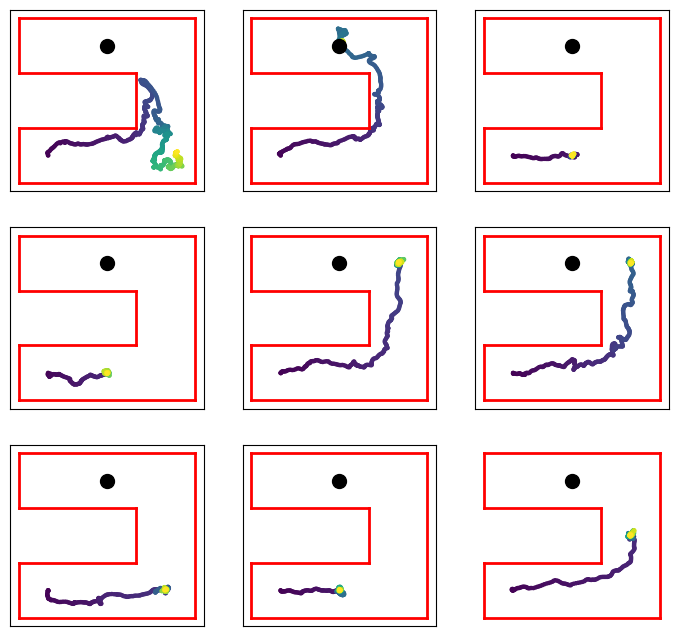

In [15]:
fig, axs = plt.subplots(3, 3, figsize=(8.5, 8))
seed = 4237
goal = [12, 8]

for i in range(9):
    trajectory = get_trajectory(seed, False, goal)
    print(i)
    positions = [sa[0].obs[:2] for sa in trajectory]

    x = [pos[0] for pos in positions]
    y = [pos[1] for pos in positions]
    
    goal = trajectory[0][0].obs[-2:]

    colors = np.linspace(0, 1, len(positions))

    axs[i//3, i%3].scatter(y, x, c=colors, cmap='viridis', s=5)
    
    axs[i//3, i%3].plot([2, 14], [2, 2], color='red', linewidth=2)   # Line from (4,4) to (16,4)
    axs[i//3, i%3].plot([14, 14], [2, 14], color='red', linewidth=2) # Line from (16,4) to (16,16)
    axs[i//3, i%3].plot([14, 2], [14, 14], color='red', linewidth=2) # Line from (16,16) to (4,16)
    
    axs[i//3, i%3].plot([2, 10], [6, 6], color='red', linewidth=2)    # Line from (4,8) to (12,8)
    axs[i//3, i%3].plot([10, 10], [6, 10], color='red', linewidth=2)  # Line from (12,8) to (12,12)
    axs[i//3, i%3].plot([10, 2], [10, 10], color='red', linewidth=2)  # Line from (12,12) to (4,12)
    
    axs[i//3, i%3].plot([2, 2], [2, 6], color='red', linewidth=2)     # Line from (4,4) to (4,8)
    axs[i//3, i%3].plot([2, 2], [10, 14], color='red', linewidth=2)   # Line from (4,12) to (1,16)
    
    axs[i//3, i%3].scatter(8, 12, color='black', s=100)
    axs[i//3, i%3].set_xticks([])
    axs[i//3, i%3].set_yticks([])

    seed += 1

plt.axis('off')
plt.show()

In [14]:
jit_env_reset = jax.jit(env.reset)
jit_env_step = jax.jit(env.step)
jit_inference_fn = jax.jit(inference_fn)

inference_fn = networks.make_inference_fn(crl_networks)
inference_fn = inference_fn(params[:2])

In [11]:
inference_fn = networks.make_inference_fn(crl_networks)
inference_fn = inference_fn(params[:2], deterministic=True)

In [43]:
def plot_trajectory_deterministic(seed):
    inference_fn = networks.make_inference_fn(crl_networks)
    inference_fn = inference_fn(params[:2], deterministic=True)
    
    jit_env_reset = jax.jit(env.reset)
    jit_env_step = jax.jit(env.step)
    jit_inference_fn = jax.jit(inference_fn)
    
    trajectory = []
    rng = jax.random.PRNGKey(seed=seed)
    state = jit_env_reset(rng=rng)
    
    for _ in range(1000):
            # rollouts.append(state.pipeline_state)
        act_rng, rng = jax.random.split(rng)
        act, _ = jit_inference_fn(state.obs, act_rng)
        trajectory.append((state,act))
        state = jit_env_step(state, act)

    positions = [sa[0].obs[:2] for sa in trajectory]

    x = [pos[0] for pos in positions]
    y = [pos[1] for pos in positions]
    
    goal = trajectory[0][0].obs[-2:]

    colors = np.linspace(0, 1, len(positions))

    plt.scatter(y, x, c=colors, cmap='viridis', s=5)
    #plt.plot([4, 16], [4, 4], color='red', linewidth=2)   # Line from (4,4) to (16,4)
    #plt.plot([16, 16], [4, 16], color='red', linewidth=2) # Line from (16,4) to (16,16)
    #plt.plot([16, 4], [16, 16], color='red', linewidth=2) # Line from (16,16) to (4,16)
    
    #plt.plot([4, 12], [8, 8], color='red', linewidth=2)    # Line from (4,8) to (12,8)
    #plt.plot([12, 12], [8, 12], color='red', linewidth=2)  # Line from (12,8) to (12,12)
    #plt.plot([12, 4], [12, 12], color='red', linewidth=2)  # Line from (12,12) to (4,12)
    
    #plt.plot([4, 4], [4, 8], color='red', linewidth=2)     # Line from (4,4) to (4,8)
    #plt.plot([4, 4], [12, 16], color='red', linewidth=2)   # Line from (4,12) to (1,16)

    plt.plot([2, 14], [2, 2], color='red', linewidth=2)   # Line from (4,4) to (16,4)
    plt.plot([14, 14], [2, 14], color='red', linewidth=2) # Line from (16,4) to (16,16)
    plt.plot([14, 2], [14, 14], color='red', linewidth=2) # Line from (16,16) to (4,16)
    
    plt.plot([2, 10], [6, 6], color='red', linewidth=2)    # Line from (4,8) to (12,8)
    plt.plot([10, 10], [6, 10], color='red', linewidth=2)  # Line from (12,8) to (12,12)
    plt.plot([10, 2], [10, 10], color='red', linewidth=2)  # Line from (12,12) to (4,12)
    
    plt.plot([2, 2], [2, 6], color='red', linewidth=2)     # Line from (4,4) to (4,8)
    plt.plot([2, 2], [10, 14], color='red', linewidth=2)   # Line from (4,12) to (1,16)
    
    plt.scatter(goal[1], goal[0], color='black', s=100)

    success_time = np.sum([t[0].metrics['success'] for t in trajectory])
    plt.title("success_time=%s" % (int(success_time)))
    
    plt.show()

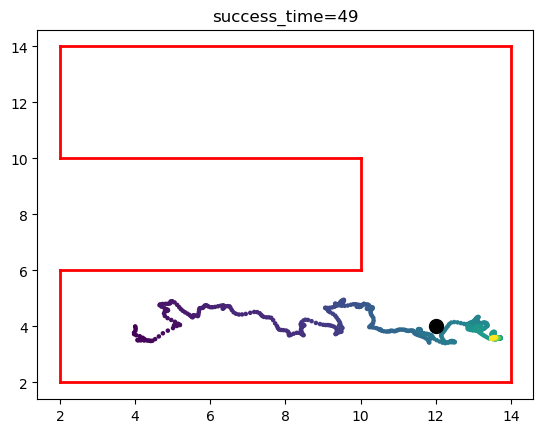

In [118]:
plot_trajectory_deterministic(0)

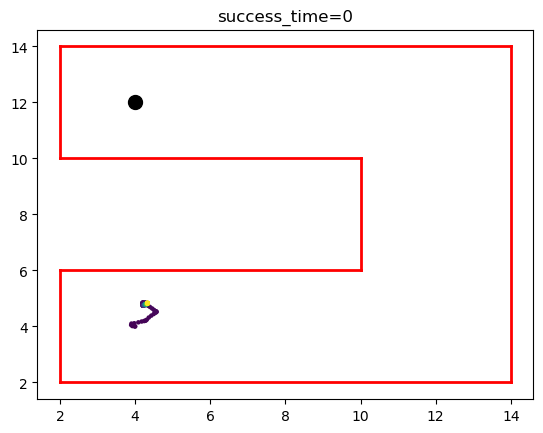

In [119]:
plot_trajectory_deterministic(1)

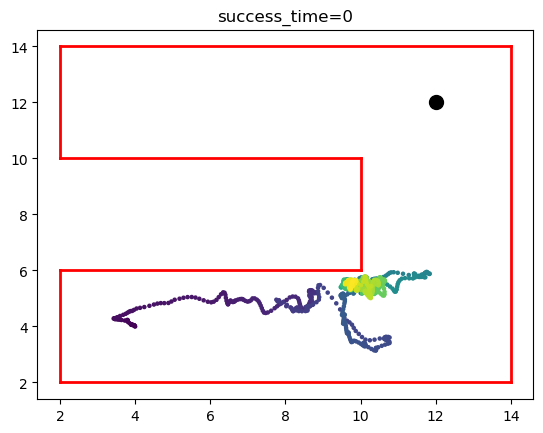

In [44]:
plot_trajectory_deterministic(5)

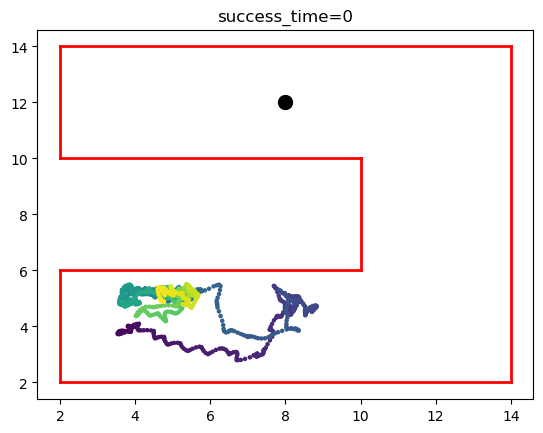

In [120]:
plot_trajectory(2)

In [17]:
trajectory = get_trajectory(2)

obs = np.array(trajectory[100][0].obs)
goal = obs[-2:]

x = np.linspace(0, 16, 70)
y = np.linspace(0, 16, 70)

X, Y = np.meshgrid(x, y)
Z = np.zeros_like(X)

rng = jax.random.PRNGKey(seed=2)

for i in range(len(x)):
    for j in range(len(y)):
        obs[:2] = (x[i], y[j])
        act_rng, rng = jax.random.split(rng)   
        action, _ = jit_inference_fn(obs, act_rng)
        act = np.array(action)
        
        encoded_state_action = sa_encoder(np.concatenate((obs[:-2], act), axis=0))
        encoded_goal = g_encoder(goal)
        l2_distance = np.linalg.norm(encoded_state_action - encoded_goal)

        Z[i, j] = -l2_distance

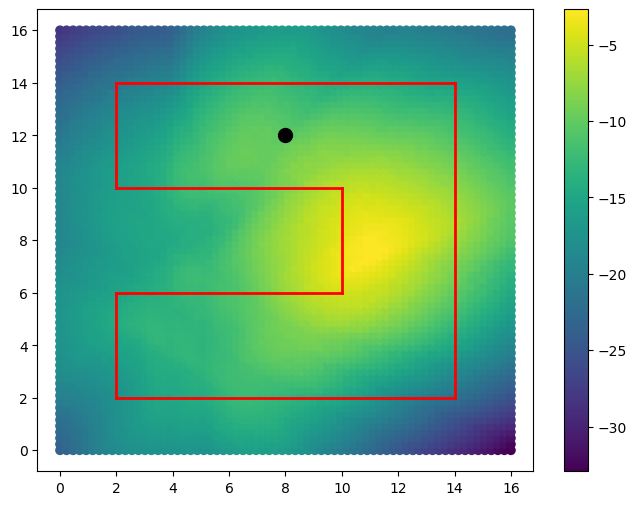

In [18]:
plt.figure(figsize=(8, 6))
plt.scatter(Y, X, c=Z, cmap='viridis', marker='o')
plt.colorbar()

plt.plot([2, 14], [2, 2], color='red', linewidth=2)   # Line from (4,4) to (16,4)
plt.plot([14, 14], [2, 14], color='red', linewidth=2) # Line from (16,4) to (16,16)
plt.plot([14, 2], [14, 14], color='red', linewidth=2) # Line from (16,16) to (4,16)

plt.plot([2, 10], [6, 6], color='red', linewidth=2)    # Line from (4,8) to (12,8)
plt.plot([10, 10], [6, 10], color='red', linewidth=2)  # Line from (12,8) to (12,12)
plt.plot([10, 2], [10, 10], color='red', linewidth=2)  # Line from (12,12) to (4,12)

plt.plot([2, 2], [2, 6], color='red', linewidth=2)     # Line from (4,4) to (4,8)
plt.plot([2, 2], [10, 14], color='red', linewidth=2)   # Line from (4,12) to (1,16)

plt.scatter(goal[1], goal[0], color='black', s=100)

plt.show()

In [23]:
rng = jax.random.PRNGKey(seed=2)
state = jit_env_reset(rng=rng)

In [26]:
state.obs[0] = 5

TypeError: '<class 'jaxlib.xla_extension.ArrayImpl'>' object does not support item assignment. JAX arrays are immutable. Instead of ``x[idx] = y``, use ``x = x.at[idx].set(y)`` or another .at[] method: https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.ndarray.at.html

In [19]:
def plot_trajectory(seed, starting_point=None):
    jit_env_reset = jax.jit(env.reset)
    jit_env_step = jax.jit(env.step)
    jit_inference_fn = jax.jit(inference_fn)
    
    trajectory = []
    rng = jax.random.PRNGKey(seed=seed)
    state = jit_env_reset(rng=rng)
    
    for _ in range(1000):
            # rollouts.append(state.pipeline_state)
        act_rng, rng = jax.random.split(rng)
        act, _ = jit_inference_fn(state.obs, act_rng)
        trajectory.append((state,act))
        state = jit_env_step(state, act)

    positions = [sa[0].obs[:2] for sa in trajectory]

    x = [pos[0] for pos in positions]
    y = [pos[1] for pos in positions]
    
    goal = trajectory[0][0].obs[-2:]

    colors = np.linspace(0, 1, len(positions))

    plt.scatter(y, x, c=colors, cmap='viridis', s=5)
    #plt.plot([4, 16], [4, 4], color='red', linewidth=2)   # Line from (4,4) to (16,4)
    #plt.plot([16, 16], [4, 16], color='red', linewidth=2) # Line from (16,4) to (16,16)
    #plt.plot([16, 4], [16, 16], color='red', linewidth=2) # Line from (16,16) to (4,16)
    
    #plt.plot([4, 12], [8, 8], color='red', linewidth=2)    # Line from (4,8) to (12,8)
    #plt.plot([12, 12], [8, 12], color='red', linewidth=2)  # Line from (12,8) to (12,12)
    #plt.plot([12, 4], [12, 12], color='red', linewidth=2)  # Line from (12,12) to (4,12)
    
    #plt.plot([4, 4], [4, 8], color='red', linewidth=2)     # Line from (4,4) to (4,8)
    #plt.plot([4, 4], [12, 16], color='red', linewidth=2)   # Line from (4,12) to (1,16)

    plt.plot([2, 14], [2, 2], color='red', linewidth=2)   # Line from (4,4) to (16,4)
    plt.plot([14, 14], [2, 14], color='red', linewidth=2) # Line from (16,4) to (16,16)
    plt.plot([14, 2], [14, 14], color='red', linewidth=2) # Line from (16,16) to (4,16)
    
    plt.plot([2, 10], [6, 6], color='red', linewidth=2)    # Line from (4,8) to (12,8)
    plt.plot([10, 10], [6, 10], color='red', linewidth=2)  # Line from (12,8) to (12,12)
    plt.plot([10, 2], [10, 10], color='red', linewidth=2)  # Line from (12,12) to (4,12)
    
    plt.plot([2, 2], [2, 6], color='red', linewidth=2)     # Line from (4,4) to (4,8)
    plt.plot([2, 2], [10, 14], color='red', linewidth=2)   # Line from (4,12) to (1,16)
    
    plt.scatter(goal[1], goal[0], color='black', s=100)

    success_time = np.sum([t[0].metrics['success'] for t in trajectory])
    plt.title("success_time=%s" % (int(success_time)))
    
    plt.show()

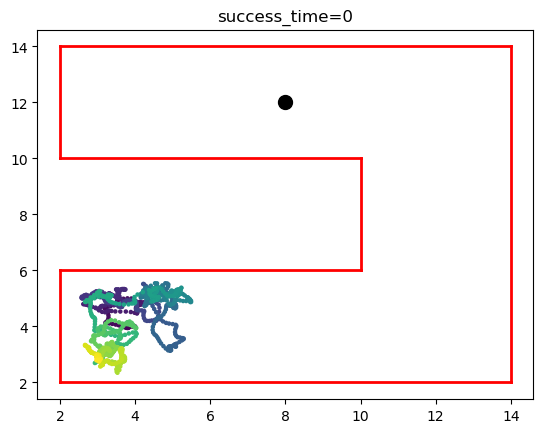

In [20]:
plot_trajectory(2)

In [102]:
trajectory = get_trajectory(5)

obs = np.array(trajectory[100][0].obs)
goal = obs[-2:]

x = np.linspace(0, 16, 70)
y = np.linspace(0, 16, 70)

X, Y = np.meshgrid(x, y)
Z = np.zeros_like(X)

rng = jax.random.PRNGKey(seed=5)

for i in range(len(x)):
    for j in range(len(y)):
        obs[:2] = (x[i], y[j])
        act_rng, rng = jax.random.split(rng)   
        action, _ = jit_inference_fn(obs, act_rng)
        act = np.array(action)
        
        encoded_state_action = sa_encoder(np.concatenate((obs[:-2], act), axis=0))
        encoded_goal = g_encoder(goal)
        l2_distance = np.linalg.norm(encoded_state_action - encoded_goal)
        Z[i, j] = -l2_distance

In [99]:
trajectory = get_trajectory(5)

In [101]:
trajectory[-1][0].metrics

{'dist': Array(5.4559846, dtype=float32),
 'distance_from_origin': Array(12.812038, dtype=float32),
 'forward_reward': Array(1.0984707, dtype=float32),
 'reward_contact': Array(-0., dtype=float32, weak_type=True),
 'reward_ctrl': Array(-2.2827187, dtype=float32),
 'reward_forward': Array(1.0984707, dtype=float32),
 'reward_survive': Array(1., dtype=float32, weak_type=True),
 'success': Array(0., dtype=float32),
 'success_easy': Array(0., dtype=float32),
 'x_position': Array(6.645996, dtype=float32),
 'x_velocity': Array(1.0984707, dtype=float32),
 'y_position': Array(10.950043, dtype=float32),
 'y_velocity': Array(-1.4237785, dtype=float32)}

In [ ]:
x = np.linspace(0, 30, 70)
y = np.linspace(0, 30, 70)

X, Y = np.meshgrid(x, y)
Z = np.zeros_like(X)

trajectory = get_trajectory(5)

obs = np.array(trajectory[100][0].obs)


for i in range(len(x)):
    for j in range(len(y)):
        obs[:2] = (x[i], y[j])
        act_rng, rng = jax.random.split(rng)   
        action, _ = jit_inference_fn(obs, act_rng)
        act = np.array(action)
        
        encoded_state_action = sa_encoder(np.concatenate((obs[:-2], act), axis=0))
        encoded_goal = g_encoder(goal)
        l2_distance = np.linalg.norm(encoded_state_action - encoded_goal)
        Q = np.exp(-l2_distance)

        Z[i, j] = Q

In [8]:
jit_env_reset = jax.jit(env.reset)
jit_env_step = jax.jit(env.step)
jit_inference_fn = jax.jit(inference_fn)

trajectory = []
rng = jax.random.PRNGKey(seed=1561894)
state = jit_env_reset(rng=rng)

for _ in range(1000):
        # rollouts.append(state.pipeline_state)
    act_rng, rng = jax.random.split(rng)
    act, _ = jit_inference_fn(state.obs, act_rng)
    trajectory.append((state,act))
    state = jit_env_step(state, act)

In [35]:
positions = [sa[0].obs[:2] for sa in trajectory]

x = [pos[0] for pos in positions]
y = [pos[1] for pos in positions]

goal = trajectory[0][0].obs[-2:]

In [17]:
colors = np.linspace(0, 1, len(positions))

In [49]:
int(trajectory[-1][0].metrics['success'])

0

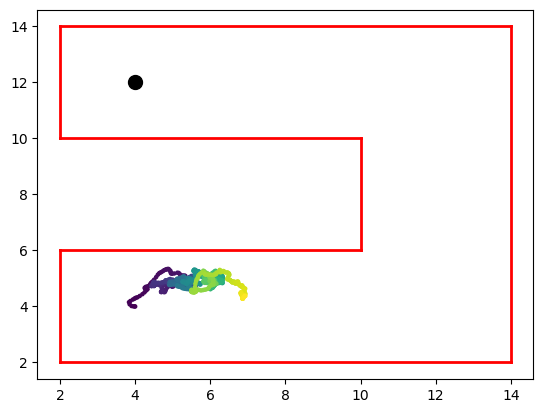

In [62]:
plt.scatter(y, x, c=colors, cmap='viridis', s=5)
plt.plot([2, 14], [2, 2], color='red', linewidth=2)   # Line from (4,4) to (16,4)
plt.plot([14, 14], [2, 14], color='red', linewidth=2) # Line from (16,4) to (16,16)
plt.plot([14, 2], [14, 14], color='red', linewidth=2) # Line from (16,16) to (4,16)

plt.plot([2, 10], [6, 6], color='red', linewidth=2)    # Line from (4,8) to (12,8)
plt.plot([10, 10], [6, 10], color='red', linewidth=2)  # Line from (12,8) to (12,12)
plt.plot([10, 2], [10, 10], color='red', linewidth=2)  # Line from (12,12) to (4,12)

plt.plot([2, 2], [2, 6], color='red', linewidth=2)     # Line from (4,4) to (4,8)
plt.plot([2, 2], [10, 14], color='red', linewidth=2)   # Line from (4,12) to (1,16)

plt.scatter(goal[1], goal[0], color='black', s=100)


plt.show()

In [23]:
jit_env_reset = jax.jit(env.reset)
jit_env_step = jax.jit(env.step)
jit_inference_fn = jax.jit(inference_fn)


state = jit_env_reset(rng=rng)
act_rng, rng = jax.random.split(rng)
action, _ = jit_inference_fn(state.obs, act_rng)

goal = np.array(state.obs)[-2:]
obs = np.array(state.obs)[:-2]
act = np.array(action)


In [24]:
goal

array([12.,  8.], dtype=float32)

In [28]:
obs[]

array([ 4.00000000e+00,  4.00000000e+00,  4.61782455e-01,  9.36429977e-01,
       -3.66912037e-03, -3.18790898e-02,  4.76423576e-02, -7.82428980e-02,
        9.16562319e-01,  9.49871615e-02, -9.65760171e-01,  7.42902830e-02,
       -9.71084535e-01,  9.06313881e-02,  9.29769218e-01, -1.03526220e-01,
       -7.14509860e-02,  2.05973253e-01, -1.12651728e-01, -2.97401119e-02,
       -8.41172691e-03,  5.73348850e-02, -1.15936324e-01,  1.31565243e-01,
        4.17854451e-03,  1.90249696e-01,  3.53522077e-02,  1.83596835e-01,
       -5.59194759e-02,  1.20000000e+01,  8.00000000e+00], dtype=float32)

In [31]:
x = np.linspace(0, 30, 70)
y = np.linspace(0, 30, 70)

X, Y = np.meshgrid(x, y)
Z = np.zeros_like(X)

goal = np.array([5, 8])


obs = np.array(state.obs)
obs[-2:] = goal


for i in range(len(x)):
    for j in range(len(y)):
        obs[:2] = (x[i], y[j])
        act_rng, rng = jax.random.split(rng)   
        action, _ = jit_inference_fn(obs, act_rng)
        act = np.array(action)
        
        encoded_state_action = sa_encoder(np.concatenate((obs[:-2], act), axis=0))
        encoded_goal = g_encoder(goal)
        l2_distance = np.linalg.norm(encoded_state_action - encoded_goal)
        Q = np.exp(-l2_distance)

        Z[i, j] = Q

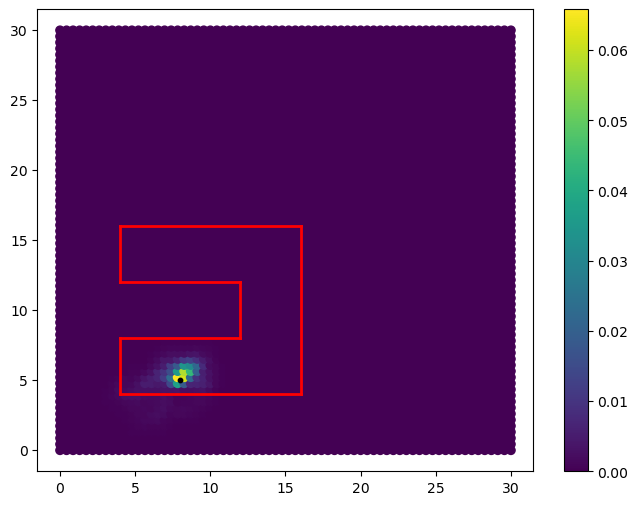

In [32]:
plt.figure(figsize=(8, 6))
plt.scatter(X, Y, c=Z, cmap='viridis', marker='o')
plt.colorbar()

plt.plot([4, 16], [4, 4], color='red', linewidth=2)   # Line from (4,4) to (16,4)
plt.plot([16, 16], [4, 16], color='red', linewidth=2) # Line from (16,4) to (16,16)
plt.plot([16, 4], [16, 16], color='red', linewidth=2) # Line from (16,16) to (4,16)

plt.plot([4, 12], [8, 8], color='red', linewidth=2)    # Line from (4,8) to (12,8)
plt.plot([12, 12], [8, 12], color='red', linewidth=2)  # Line from (12,8) to (12,12)
plt.plot([12, 4], [12, 12], color='red', linewidth=2)  # Line from (12,12) to (4,12)

plt.plot([4, 4], [4, 8], color='red', linewidth=2)     # Line from (4,4) to (4,8)
plt.plot([4, 4], [12, 16], color='red', linewidth=2)   # Line from (4,12) to (1,16)

plt.scatter(goal[1], goal[0], color='black', s=10)

plt.show()

In [33]:
Z = np.log(Z)

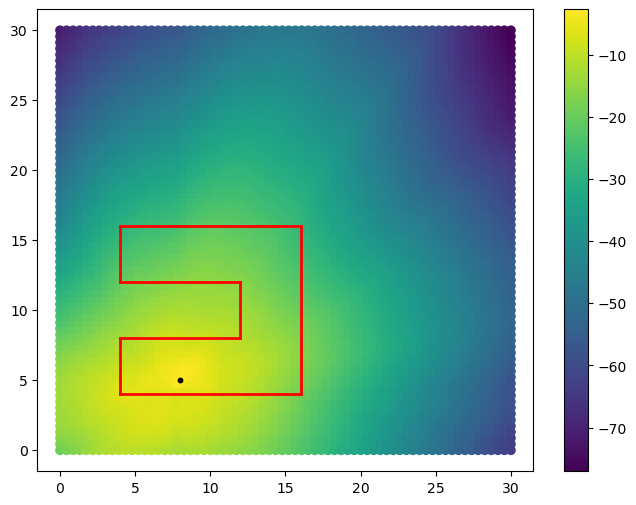

In [34]:
plt.figure(figsize=(8, 6))
plt.scatter(X, Y, c=Z, cmap='viridis', marker='o')
plt.colorbar()

plt.plot([4, 16], [4, 4], color='red', linewidth=2)   # Line from (4,4) to (16,4)
plt.plot([16, 16], [4, 16], color='red', linewidth=2) # Line from (16,4) to (16,16)
plt.plot([16, 4], [16, 16], color='red', linewidth=2) # Line from (16,16) to (4,16)

plt.plot([4, 12], [8, 8], color='red', linewidth=2)    # Line from (4,8) to (12,8)
plt.plot([12, 12], [8, 12], color='red', linewidth=2)  # Line from (12,8) to (12,12)
plt.plot([12, 4], [12, 12], color='red', linewidth=2)  # Line from (12,12) to (4,12)

plt.plot([4, 4], [4, 8], color='red', linewidth=2)     # Line from (4,4) to (4,8)
plt.plot([4, 4], [12, 16], color='red', linewidth=2)   # Line from (4,12) to (1,16)

plt.scatter(goal[1], goal[0], color='black', s=10)

plt.show()

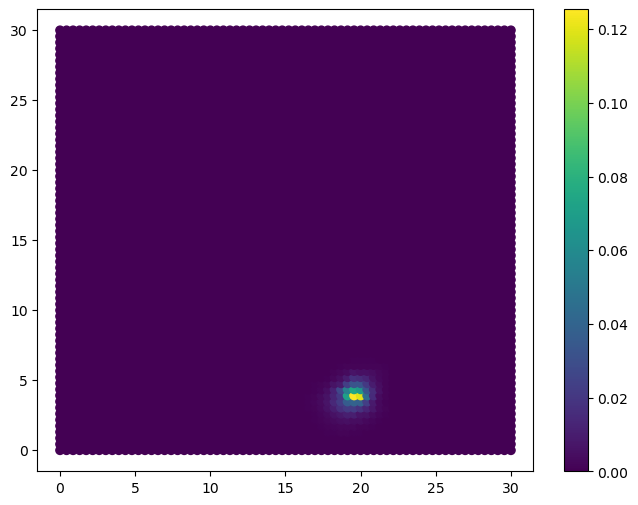

In [25]:
plt.figure(figsize=(8, 6))
plt.scatter(X, Y, c=Z, cmap='viridis', marker='o')
plt.colorbar()
plt.show()

In [26]:
Z = np.log(Z)

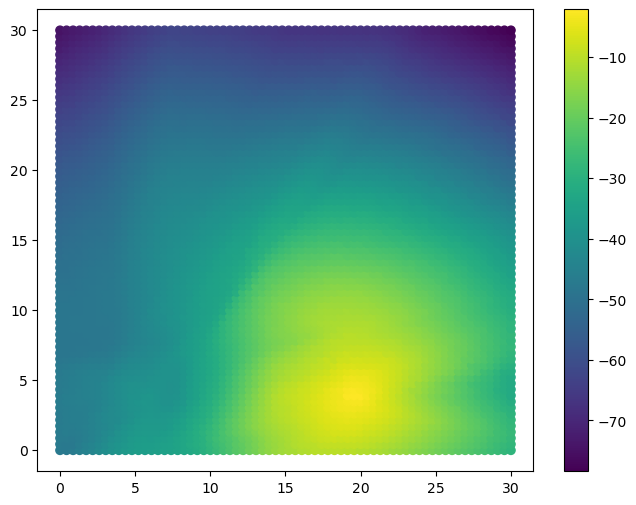

In [27]:
plt.figure(figsize=(8, 6))
plt.scatter(X, Y, c=Z, cmap='viridis', marker='o')
plt.colorbar()
plt.show()

In [35]:
NUM_EPISODES = 1

jit_env_reset = jax.jit(env.reset)
jit_env_step = jax.jit(env.step)
jit_inference_fn = jax.jit(inference_fn)


trajectories = []
rollouts = []

for episode in range(NUM_EPISODES):
    trajectory = []
    rng = jax.random.PRNGKey(seed=episode)
    state = jit_env_reset(rng=rng)
    for _ in range(1000):
        rollouts.append(state.pipeline_state)
        act_rng, rng = jax.random.split(rng)
        act, _ = jit_inference_fn(state.obs, act_rng)
        trajectory.append((state,act))
        state = jit_env_step(state, act)
    trajectories.append(trajectory)

In [26]:
s, a = trajectories[0][0]

In [28]:
s.obs

Array([ 4.00300217e+00,  3.95677280e+00,  5.08071601e-01,  9.34209585e-01,
        9.99258235e-02, -1.29214525e-02, -5.92630170e-02,  8.33190456e-02,
        1.01426196e+00, -9.48459655e-02, -1.03614187e+00,  2.44859233e-02,
       -1.09609950e+00, -5.72115667e-02,  9.78265464e-01,  2.13161767e-01,
        2.26637632e-01, -1.79885291e-02, -1.35182172e-01,  2.42620725e-02,
       -1.24832086e-01, -7.41649941e-02, -1.10123105e-01, -1.52591011e-02,
        1.39247388e-01, -1.52174681e-01, -3.90023850e-02,  5.40192239e-03,
        1.56412572e-01,  4.00000000e+00,  1.99999981e+01], dtype=float32)

In [36]:
HTML(html.render(env.sys.tree_replace({'opt.timestep': env.dt}), rollouts))

In [ ]:
TRAJECTORY_TO_DRAW = 0

raw_observations = np.array([state.obs for (state, _) in trajectories[TRAJECTORY_TO_DRAW]])
actions = np.array([act for (_, act) in trajectories[TRAJECTORY_TO_DRAW]])

observations = raw_observations[:, :env.obs_dim]

encoded_sa = sa_encoder(jp.concatenate((observations, actions), axis = 1))

scaled_encodings = StandardScaler().fit_transform(encoded_sa)
features = PCA(n_components=2).fit_transform(scaled_encodings)

plt.scatter(features[:,0], features[:,1], c=np.arange(0, 1000))
plt.colorbar(label="timestep")
plt.title(f"Trajectory (s,a) embeddings, {args.env_name}, {CKPT_NAME}")